# <font color='HotPink'>**Data Mining Project 2025/2026 - Group 94** <br></font> Amazing International Airlines Inc.


**Diogo Henrique Lopes de Carvalho** ***(20221935)***

**Maria Luiza Salum Alves Corrêa** ***(20221902)***

**Ricardo Miguel Silva Martins Pereira** ***(20250343)***

*** 

## **Index**

***First Delivery***
1. [Business Understanding](#1)
1. [Imports](#2)
1. [Data Understanding](#3)
    1. [The Dataset](#3_1)
1. [Data Preparation](#4)
    1. [Data Cleaning](#4_1)
    1. [Variable Classification](#4_2)
    1. [Summary Statistics](#4_3)
    1. [Data Visualisation](#4_4)
    1. [Feature Engineering](#4_5)

***Second Delivery***

5. [Clustering](#5)
5. [Evaluation](#6)
5. [Suggestions](#7)

***

## 1. <a id="1">Business Understanding</a>

Our client, **Amazing International Airlines Inc.**, tasked our consulting team with the analysis of their customer loyalty membership data and corresponding flight activity collected over a three-year period. <br>

The goal of our analysis is to create useful insights through a segmentation process that consists of grouping and viewing the available data by different lenses; such as *economic contribution*, *behaviours in purchases and travels*, and *demographic divisions*. <br>

After sharing the insights, our team will evaluate the results and give AIAI suggestions on how to adapt their services, rewards and communications to meet the needs of the most relevant groups found.

***

## 2. <a id="2">Imports</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
import itertools


# import itertools

***

## 3. <a id="3">Data Understanding</a>

### 3.1. <a id="3_1">The Dataset</a>

The dataset given to our team consists of three `csv` files:

- `DM_AIAI_CustomerDB.csv`

*Three (3) years of data related to Customers in the Loyalty Program*
- `DM_AIAI_FlightsDB.csv`

*Three (3) years of data related to Flights of the Loyalty Program Members*
- `DM_AIAI_Metadata.csv`

*Description of the Variables in the CustomerDB and FlightDB Files*

In [4]:
customerDB = pd.read_csv("data/DM_AIAI_CustomerDB.csv", sep=",")
flightDB = pd.read_csv("data/DM_AIAI_FlightsDB.csv", sep=",")
metadata = pd.read_csv("data/DM_AIAI_Metadata.csv", sep=";")

customerDB_copy = customerDB.copy()
flightDB_copy = flightDB.copy()

In [ ]:
pd.set_option("display.max_colwidth", None)  # To see full descriptions
metadata

,CustomerDB,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,Variable,Description,NaN
1,NaN,Loyalty#,Unique customer identifier for loyalty program members,NaN
2,NaN,First Name,Customer's first name,NaN
3,NaN,Last Name,Customer's last name,NaN
4,NaN,Customer Name,Customer's full name (concatenated),NaN
5,NaN,Country,Customer's country of residence,NaN
6,NaN,Province or State,Customer's province or state,NaN
7,NaN,City,Customer's city of residence,NaN
8,NaN,Latitude,Geographic latitude coordinate of customer location,NaN
9,NaN,Longitude,Geographic longitude coordinate of customer location,NaN


#### Initial Conclusions
*What conclusions can we make from the metadata?*

##### Customer DB

**Useful:**
- `Loyalty#`: Will be used. Connects Customer's and Flights' information.

**Will be Dropped:**
- `First Name`, `Last Name`, `Customer Name`: First two are redundant since we have the full name, but this information is irrelevant for clustering anyways. We'll drop everything after data cleaning. *(Keeping `Customer Name` for now to check something with the IDs)*
- `Latitude`, `Longitude`, `Postal Code`: No need for specific customer location. *(Spoilers: We checked, some coordinates lead to nowhere and just make no sense overall)*

**No Conclusions:** <br>
*May be relevant. No conclusions about data quality from metadata.*
- `Country`
- `Province or State`
- `City`
- `Postal Code`
- `Gender`
- `Education`
- `Location Code`
- `Income`
- `Marital Status`
- `Loyalty Status`
- `EnrollmentDataOpening`
- `CancellationDate`
- `Customer Lifetime Value`
- `EnrollmentType`

In [ ]:
customerDB_copy.drop(columns=["First Name", "Last Name", "Latitude", "Longitude", "Postal code"], inplace=True)
customerDB_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16921 entries, 0 to 16920
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               16921 non-null  int64  
 1   Loyalty#                 16921 non-null  int64  
 2   Customer Name            16921 non-null  object 
 3   Country                  16921 non-null  object 
 4   Province or State        16921 non-null  object 
 5   City                     16921 non-null  object 
 6   Gender                   16921 non-null  object 
 7   Education                16921 non-null  object 
 8   Location Code            16921 non-null  object 
 9   Income                   16901 non-null  float64
 10  Marital Status           16921 non-null  object 
 11  LoyaltyStatus            16921 non-null  object 
 12  EnrollmentDateOpening    16921 non-null  object 
 13  CancellationDate         2310 non-null   object 
 14  Customer Lifetime Valu

From the non-null count, we can see that there are only three variables with missing values: `Income`, `CancellationDate` and `Customer Lifetime Value`. Having null values in `CancellationDate` clearly makes sense as we don't expect all customers in the dataset to have cancelled their membership. For `Income` and `Customer Lifetime Value`, we'll try to understand the reason later.

In [ ]:
# There's a random column with no name, let's drop it
customerDB_copy.drop(columns=["Unnamed: 0"], inplace=True)

##### Flights DB

**Useful:**
- `Loyalty#`: Will be used. Connects Customer's and Flights' information.

**Will be Dropped:**
- `YearMonthDate`: Contains the same info as `Month` and `Year` with a constant date.
- `DollarCostPointsRedeemed`: Redundant. `PointsRedeemed` gives the same information.

**No Conclusions:** <br>
*May be relevant. No conclusions about data quality from metadata.*
- `Year`
- `Month`
- `NumFlights`
- `NumFlightsWithCompanions`*
- `DistanceKM`
- `PointsAccumulated`
- `PointsRedeemed`

**We will assume `NumFlightsWithCompanions` is also a "count by month" even though it's not mentioned in the metadata.*

In [ ]:
flightDB_copy.drop(columns=["YearMonthDate", "DollarCostPointsRedeemed"], inplace=True)
flightDB_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608436 entries, 0 to 608435
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Loyalty#                  608436 non-null  int64  
 1   Year                      608436 non-null  int64  
 2   Month                     608436 non-null  int64  
 3   NumFlights                608436 non-null  float64
 4   NumFlightsWithCompanions  608436 non-null  float64
 5   DistanceKM                608436 non-null  float64
 6   PointsAccumulated         608436 non-null  float64
 7   PointsRedeemed            608436 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 37.1 MB


There are no null values in any variable. We'll take a closer look into the dataset when preparing the data. There might be missing values that are non-null since they could look like "-", "Null", "Missing", etc.

***

## 4. <a id="4">Data Preparation</a>

There's a possibility of having some rows that the only plausible option is to remove from the dataset due to uncorrectable errors. For this reason, we are going to define variables to keep track of how many rows we are dropping.

We are going to assume that an acceptable threshold is 5% of the dataset.

In [ ]:
customer_dropped_rows = 0
customer_original_rows = customerDB.shape[0]
customer_dropped_percentage = 0
customer_available_to_drop = (customer_original_rows * 0.05) - customer_dropped_rows
print(f"Available rows to drop in customerDB: {customer_available_to_drop} ({(customer_available_to_drop/customer_original_rows)*100:.0f}%)")

flight_dropped_rows = 0
flight_original_rows = flightDB.shape[0]
flight_dropped_percentage = 0
flight_available_to_drop = (flight_original_rows * 0.05) - flight_dropped_rows
print(f"Available rows to drop in flightDB: {flight_available_to_drop} ({(flight_available_to_drop/flight_original_rows)*100:.0f}%)")

Available rows to drop in customerDB: 846.0500000000001 (5%)
Available rows to drop in flightDB: 30421.800000000003 (5%)


In [ ]:
customerDB_copy.head()

,Loyalty#,Customer Name,Country,Province or State,City,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
0,480934,Cecilia Householder,Canada,Ontario,Toronto,female,Bachelor,Urban,70146.0,Married,Star,2/15/2019,NaN,3839.14,Standard
1,549612,Dayle Menez,Canada,Alberta,Edmonton,male,College,Rural,0.0,Divorced,Star,3/9/2019,NaN,3839.61,Standard
2,429460,Necole Hannon,Canada,British Columbia,Vancouver,male,College,Urban,0.0,Single,Star,7/14/2017,1/8/2021,3839.75,Standard
3,608370,Queen Hagee,Canada,Ontario,Toronto,male,College,Suburban,0.0,Single,Star,2/17/2016,NaN,3839.75,Standard
4,530508,Claire Latting,Canada,Quebec,Hull,male,Bachelor,Suburban,97832.0,Married,Star,10/25/2017,NaN,3842.79,2021 Promotion


In [ ]:
# Seeing the different values in each variable and if they're less than 15, printing them bellow
for variable in customerDB_copy.columns:
    print(f"{variable}: {customerDB_copy[variable].nunique()} unique values\n")
    if customerDB_copy[variable].nunique() < 15:
        print(f"{customerDB_copy[variable].value_counts()}\n")

Loyalty#: 16757 unique values

Customer Name: 16921 unique values

Country: 1 unique values

Country
Canada    16921
Name: count, dtype: int64

Province or State: 11 unique values

Province or State
Ontario                 5468
British Columbia        4416
Quebec                  3311
Alberta                 1008
Manitoba                 676
New Brunswick            652
Nova Scotia              541
Saskatchewan             412
Newfoundland             258
Yukon                    112
Prince Edward Island      67
Name: count, dtype: int64

City: 29 unique values

Gender: 2 unique values

Gender
female    8497
male      8424
Name: count, dtype: int64

Education: 5 unique values

Education
Bachelor                10586
College                  4283
High School or Below      792
Doctor                    742
Master                    518
Name: count, dtype: int64

Location Code: 3 unique values

Location Code
Suburban    5716
Rural       5668
Urban       5537
Name: count, dtype: int64

Inc

In [ ]:
flightDB_copy.head()

,Loyalty#,Year,Month,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed
0,413052,2021,12,2.0,2.0,9384.0,938.0,0.0
1,464105,2021,12,0.0,0.0,0.0,0.0,0.0
2,681785,2021,12,10.0,3.0,14745.0,1474.0,0.0
3,185013,2021,12,16.0,4.0,26311.0,2631.0,3213.0
4,216596,2021,12,9.0,0.0,19275.0,1927.0,0.0


In [ ]:
# Seeing the different values in each variable and if they're less than 15, printing them bellow
for variable in flightDB_copy.columns:
    print(f"{variable}: {flightDB_copy[variable].nunique()} unique values\n")
    if flightDB_copy[variable].nunique() < 15:
        print(f"{flightDB_copy[variable].value_counts()}\n")

Loyalty#: 16737 unique values

Year: 3 unique values

Year
2021    202812
2020    202812
2019    202812
Name: count, dtype: int64

Month: 12 unique values

Month
12    50703
6     50703
5     50703
4     50703
3     50703
2     50703
1     50703
11    50703
10    50703
9     50703
8     50703
7     50703
Name: count, dtype: int64

NumFlights: 41 unique values

NumFlightsWithCompanions: 22 unique values

DistanceKM: 66762 unique values

PointsAccumulated: 37064 unique values

PointsRedeemed: 8146 unique values



### 4.1. <a id="4_1">Data Cleaning</a>

##### Loyalty# *(+ Customer Name)*

In [ ]:
# Confirming how many rows have repeated Loyalty#
print(customerDB_copy["Loyalty#"].duplicated().sum())
# Confirming if the whole row is duplicated
print(customerDB_copy.duplicated().sum())

164
0


We kept `Customer Name` before so we could check if they're the same for repeated Loyalty IDs, but this is not the case as the unique values count is 16921. This means that we cannot use the name to fix the issue with duplicated IDs (they're not the same person).

We could assign new random values to the repeated IDs, but the FlightsDB dataset is connected to each customer through this variable, so it makes no sense to change it in the CustomerDB since this would mean that they have no associated flights.

We'll now drop `Customer Name` and remove the rows with repeated Loyalty ID.

In [ ]:
# Dropping Customer Name
customerDB_copy.drop(columns=["Customer Name"], inplace=True)

In [ ]:
# Keeping only one of the duplicated rows and adding the number of dropped rows to the counter
for loyalty_id in customerDB_copy["Loyalty#"][customerDB_copy["Loyalty#"].duplicated()]: # for each duplicated Loyalty#
    duplicated_rows = customerDB_copy[customerDB_copy["Loyalty#"] == loyalty_id] # getting the duplicated rows
    customerDB_copy.drop(duplicated_rows.index[1:], inplace=True) # dropping from the second to the last (just in case there are more than 2)
    customer_dropped_rows += len(duplicated_rows) - 1 # adding the number of dropped rows to the counter

customer_dropped_percentage = customer_dropped_rows / customer_original_rows * 100
customer_available_to_drop -= customer_dropped_rows
print(f"Total dropped rows: {customer_dropped_rows}, which is {customer_dropped_percentage:.2f}% of the original dataset. We can still drop {customer_available_to_drop} rows.")

Total dropped rows: 164, which is 0.97% of the original dataset. We can still drop 682.0500000000001 rows.


##### Country

`Country` is a constant feature (Canada). We'll drop this column.

In [ ]:
# Dropping Country
customerDB_copy.drop(columns=["Country"], inplace=True)

#### City

Checking if all cities in the list are Canadian cities.

In [ ]:
customerDB_copy["City"].unique()

array(['Toronto', 'Edmonton', 'Vancouver', 'Hull', 'Whitehorse',
       'Trenton', 'Montreal', 'Dawson Creek', 'Quebec City', 'Moncton',
       'Fredericton', 'Ottawa', 'Tremblant', 'Calgary', 'Whistler',
       'Thunder Bay', 'Peace River', 'Winnipeg', 'Sudbury',
       'West Vancouver', 'Halifax', 'London', 'Victoria', 'Regina',
       'Kelowna', "St. John's", 'Kingston', 'Banff', 'Charlottetown'],
      dtype=object)

#### Income - Customer Lifetime Value

We'll see if the null values in `Income` are related to the null values in `Customer Lifetime Value`.

In [ ]:
income_null = customerDB_copy[customerDB_copy["Income"].isna()]
clv_null = customerDB_copy[customerDB_copy["Customer Lifetime Value"].isna()]
income_clv_null = customerDB_copy[(customerDB_copy["Income"].isna()) & (customerDB_copy["Customer Lifetime Value"].isna())]
print(f"Income null values: {len(income_null)}\nCLV null values: {len(clv_null)}\nBoth null values: {len(income_clv_null)}")

Income null values: 20
CLV null values: 20
Both null values: 20


In [ ]:
# seeing these customers in customerDB_copy
customerDB_copy.loc[income_clv_null.index]

,Loyalty#,Province or State,City,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
16901,999987,New Brunswick,Fredericton,female,Bachelor,Urban,NaN,Single,Star,3/7/2017,3/7/2017,NaN,Standard
16902,999988,Quebec,Montreal,male,College,Rural,NaN,Single,Star,8/22/2017,8/22/2017,NaN,Standard
16903,999989,Ontario,Trenton,male,College,Rural,NaN,Married,Star,9/12/2015,9/12/2015,NaN,Standard
16904,999990,New Brunswick,Moncton,female,College,Rural,NaN,Married,Star,6/10/2019,6/10/2019,NaN,Standard
16905,999991,New Brunswick,Fredericton,female,College,Suburban,NaN,Married,Star,7/20/2019,7/20/2019,NaN,Standard
16906,999992,Ontario,Toronto,male,College,Suburban,NaN,Single,Star,3/27/2021,3/27/2021,NaN,Standard
16907,999993,British Columbia,Dawson Creek,female,College,Suburban,NaN,Married,Star,1/27/2015,1/27/2015,NaN,Standard
16908,999994,Ontario,Ottawa,female,College,Rural,NaN,Married,Star,5/5/2016,5/5/2016,NaN,Standard
16909,999995,Ontario,Ottawa,female,College,Suburban,NaN,Married,Star,3/2/2020,3/2/2020,NaN,Standard
16910,999996,Ontario,Toronto,female,Bachelor,Suburban,NaN,Single,Star,9/14/2018,9/14/2018,NaN,Standard


Now we know they're the same customers.

Also, we can see that each one of these customers have the same `EnrollmentDateOpening` and `CancellationDate`, which makes us believe that they will have no relevant information in the flight dataset. If they don't, we'll just drop the rows.

In [ ]:
# seeing if there are any Loyalty# in customerDB_copy that are not in flightDB_copy
missing_loyalty = customerDB_copy.index.difference(flightDB_copy["Loyalty#"].unique())
# seeing if they're the ones with null values in Customer Lifetime Value
clv_null_loyalty = customerDB_copy[customerDB_copy["Customer Lifetime Value"].isna()].index
meets = []
for index in missing_loyalty:
    if index in clv_null_loyalty:
        meets.append(index)
print(f"Loyalty# missing in flightDB_copy and null CLV/Income: \n{meets}\nTotal: {len(meets)}")

Loyalty# missing in flightDB_copy and null CLV/Income: 
[16901, 16902, 16903, 16904, 16905, 16906, 16907, 16908, 16909, 16910, 16911, 16912, 16913, 16914, 16915, 16916, 16917, 16918, 16919, 16920]
Total: 20


As expected, they have no flight information at all! Let's drop them.

In [ ]:
customerDB_copy.drop(index=meets, inplace=True)
customer_dropped_rows += len(meets)
customer_dropped_percentage = customer_dropped_rows / customer_original_rows * 100
customer_available_to_drop -= len(meets)
print(f"Total dropped rows: {customer_dropped_rows}, which is {customer_dropped_percentage:.2f}% of the original dataset. We can still drop {customer_available_to_drop} rows.")

Total dropped rows: 184, which is 1.09% of the original dataset. We can still drop 662.0500000000001 rows.


Let's see the values equal to zero...

In [ ]:
income_zero = customerDB_copy[customerDB_copy["Income"] == 0]
clv_zero = customerDB_copy[customerDB_copy["Customer Lifetime Value"] == 0]
income_clv_zero = customerDB_copy[(customerDB_copy["Income"] == 0) & (customerDB_copy["Customer Lifetime Value"] == 0)]
print(f"Income zero values: {len(income_zero)}\nCLV zero values: {len(clv_zero)}\nBoth zero values: {len(income_clv_zero)}\n")
print(income_zero["Customer Lifetime Value"])

Income zero values: 4238
CLV zero values: 0
Both zero values: 0

1         3839.61
2         3839.75
3         3839.75
6         3857.95
13        3871.07
14        3872.22
18        3883.40
19        3885.46
20        3885.46
21        3885.46
22        3885.46
23        3886.50
30        3891.58
38        3907.03
40        3914.72
41        3914.72
42        3915.80
48        3920.51
66        3958.00
67        3961.59
75        3974.86
76        3974.86
84        3992.58
85        3995.36
87        3997.48
95        4015.21
98        4016.54
99        4019.38
100       4019.38
103       4025.10
105       4035.77
113       4064.11
115       4068.09
119       4079.13
130       4101.94
133       4108.26
134       4109.31
141       4117.37
145       4121.25
149       4132.59
153       4145.02
154       4152.65
155       4157.70
160       4165.99
161       4167.09
162       4167.09
171       4185.76
172       4191.06
174       4196.65
182       4217.86
183       4217.86
184       4221.31

We'll try to understand if there's a pattern for the 0$ income values in the Data Visualisation section. Maybe a specific type of customer decided to keep their income a secret..? We don't know yet, but we can see that these customers, even though they have no revealed `Income`, have an estimated CLV.

#### CancellationDate

Checking if there are dates in `CancellationDate` that are earlier than dates in `EnrollmentDateOpening`.

In [ ]:
customerDB_copy["EnrollmentDateOpening"] = pd.to_datetime(customerDB_copy["EnrollmentDateOpening"], errors="coerce")
customerDB_copy["CancellationDate"] = pd.to_datetime(customerDB_copy["CancellationDate"], errors="coerce")
invalid_dates = customerDB_copy[customerDB_copy["CancellationDate"] <= customerDB_copy["EnrollmentDateOpening"]]
print(f"Number of rows with CancellationDate before EnrollmentDateOpening: {len(invalid_dates)}")
invalid_dates

Number of rows with CancellationDate before EnrollmentDateOpening: 203


,Loyalty#,Province or State,City,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
72,357549,British Columbia,Whistler,female,Bachelor,Rural,60817.0,Single,Star,2021-09-21,2019-05-21,3964.73,Standard
77,265297,Manitoba,Winnipeg,female,Bachelor,Urban,39101.0,Married,Star,2021-07-17,2019-03-17,3978.67,Standard
176,845613,Quebec,Montreal,male,Bachelor,Urban,30598.0,Married,Star,2021-10-13,2019-06-13,4198.03,Standard
210,830547,British Columbia,Vancouver,male,Bachelor,Rural,26245.0,Single,Star,2021-05-11,2019-01-11,4271.20,Standard
304,514900,Ontario,Toronto,female,Bachelor,Urban,80892.0,Married,Star,2021-07-20,2019-03-20,4425.91,Standard
556,381786,Newfoundland,St. John's,male,High School or Below,Urban,29177.0,Married,Star,2021-09-14,2019-05-14,4766.94,Standard
645,273353,Quebec,Montreal,male,Master,Urban,18866.0,Married,Star,2021-07-18,2019-03-18,4873.44,Standard
678,698180,British Columbia,Vancouver,female,High School or Below,Urban,24383.0,Single,Star,2021-06-13,2019-02-13,4897.04,Standard
802,455287,British Columbia,Vancouver,female,Bachelor,Rural,69678.0,Divorced,Aurora,2021-07-18,2019-03-18,5021.69,Standard
881,456752,Nova Scotia,Halifax,male,Bachelor,Rural,26890.0,Married,Aurora,2021-09-16,2019-05-16,5119.90,Standard


In [ ]:
# Seeing the total flight dataset data per customer in the invalid_dates
invalid_loyalty_numbers = invalid_dates["Loyalty#"].to_numpy()
invalid_flights = flightDB_copy[flightDB_copy["Loyalty#"].isin(invalid_loyalty_numbers)]
invalid_flights_grouped = invalid_flights.groupby("Loyalty#").agg({
    "NumFlights": "sum",
    "NumFlightsWithCompanions": "sum",
    "DistanceKM": "sum",
    "PointsAccumulated": "sum"
}).reset_index()
invalid_flights_grouped

,Loyalty#,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated
0,102615,8.0,0.0,22608.0,2260.00
1,103362,9.0,1.0,11840.0,1184.00
2,103985,18.0,6.0,41615.0,4160.00
3,116562,35.0,2.0,80284.0,8027.00
4,122858,32.0,7.0,81345.0,8133.00
5,124351,106.4,17.1,236200.4,23615.44
6,131956,34.0,5.0,44586.0,4456.00
7,134000,19.0,7.0,66799.0,6678.00
8,134012,18.0,9.0,47185.0,4718.00
9,150141,16.0,10.0,26333.0,2632.00


Since we have relevant flight data for customers with invalid dates, we are going to assume that the customer had a previous membership, cancelled it, and then decided to become a member once again.

For this reason, we're just going to replace these dates in `CancellationDate` with Na.

*We're not adding this to the dropped rows count as we only did a replacement.*

In [ ]:
for _row in invalid_dates:
    customerDB_copy.loc[invalid_dates.index, "CancellationDate"] = pd.NaT

#### CustomerDB - FlightDB Relation

In [ ]:
flightDB_copy.shape[0]/customerDB_copy.shape[0]

36.352751389137836

Every customer in the loyalty program should have a row for each one of the 36 months in the dataset. The number above shows that there are more months registered than customers. We'll take a look into this.

In [ ]:
# for each loyalty number, counting how many rows there are in the flights dataset
flight_counts = flightDB_copy["Loyalty#"].value_counts()
loyalty_over_36 = flight_counts[flight_counts > 36]
print(f"Number of Loyalty# with more than 36 rows: {len(loyalty_over_36)}")

# for each loyalty number, counting how many months are missing in the flights dataset
months_per_loyalty = flightDB_copy.groupby("Loyalty#").size()
missing_months = months_per_loyalty[months_per_loyalty < 36]
print(f"Number of Loyalty# with less than 36 months: {len(missing_months)}")

Number of Loyalty# with more than 36 rows: 163
Number of Loyalty# with less than 36 months: 0


In [ ]:
# showing the rows for one Loyalty# with more than 36 rows
flightDB_copy[flightDB_copy["Loyalty#"] == loyalty_over_36.index[0]]

,Loyalty#,Year,Month,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed
5211,678205,2020,5,0.0,0.0,0.0,0.0,0.0
11558,678205,2020,5,0.0,0.0,0.0,0.0,0.0
19366,678205,2020,5,0.0,0.0,0.0,0.0,0.0
21029,678205,2020,4,0.0,0.0,0.0,0.0,0.0
22477,678205,2020,4,0.0,0.0,0.0,0.0,0.0
27589,678205,2020,4,0.0,0.0,0.0,0.0,0.0
40661,678205,2020,2,0.0,0.0,0.0,0.0,0.0
41908,678205,2020,2,0.0,0.0,0.0,0.0,0.0
44481,678205,2020,3,0.0,0.0,0.0,0.0,0.0
46246,678205,2020,3,0.0,0.0,0.0,0.0,0.0


For each repeated month, we'll keep the row with the less amount of null values.

In [ ]:
non_null_counts = flightDB_copy.notna().sum(axis=1) # counting non-null values in each row
row_to_keep = (flightDB_copy.assign(non_null_count=non_null_counts).groupby(["Loyalty#", "Year", "Month"])["non_null_count"].idxmax()) # getting the index of the row with the most non-null values for each Loyalty#, Year, Month
flightDB_copy = flightDB_copy.loc[row_to_keep].copy() # keeping only the rows with the most non-null values

# updating the dropped rows counter
flight_dropped_rows = flight_original_rows - flightDB_copy.shape[0]
flight_available_to_drop -= flight_dropped_rows

print(f"Total dropped rows: {flight_dropped_rows}, which is {(flight_dropped_rows/flight_original_rows)*100:.2f}% of the original dataset. We can still drop {flight_available_to_drop} rows.")

Total dropped rows: 5904, which is 0.97% of the original dataset. We can still drop 24517.800000000003 rows.


*Side comment: the same percentage of rows was dropped when we were cleaning the duplicate customers... This could mean that the people dropped in this previous step had an already existing ID assigned to them when creating their account. This would have mixed their data with the other customer with the existing ID.*

*There's no way of identifying which flight information is related to each one of these customers, so we'll need to work with what we have.*

In [ ]:
# for each loyalty number, counting how many rows there are in the flights dataset
flight_counts = flightDB_copy["Loyalty#"].value_counts()
loyalty_over_36 = flight_counts[flight_counts > 36]
print(f"Number of Loyalty# with more than 36 rows: {len(loyalty_over_36)}")

# for each loyalty number, counting how many months are missing in the flights dataset
months_per_loyalty = flightDB_copy.groupby("Loyalty#").size()
missing_months = months_per_loyalty[months_per_loyalty < 36]
print(f"Number of Loyalty# with less than 36 months: {len(missing_months)}")

Number of Loyalty# with more than 36 rows: 0
Number of Loyalty# with less than 36 months: 0


### 4.2. <a id="4_2">Variable Classification</a>

*It makes no sense to make `Loyalty#` the index in the flightDB dataset as the same customer may have multiple flights.*

In [ ]:
# Making Loyalty# the index for the customerDB
customerDB_copy.set_index("Loyalty#", inplace=True)

We're going to categorise the different variables in both datasets.


For `customerDB`, we'll have Nominal, Ordinal, Numerical, and DateTime variables. We're diving the categorical variables in Nominal and Ordinal because the latter will have its variables used for the Encoded category.

For `flightDB`, we'll only have Numerical and DateTime variables since this dataset has no categorical variables.

In [ ]:
customerDB_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16737 entries, 480934 to 652627
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Province or State        16737 non-null  object        
 1   City                     16737 non-null  object        
 2   Gender                   16737 non-null  object        
 3   Education                16737 non-null  object        
 4   Location Code            16737 non-null  object        
 5   Income                   16737 non-null  float64       
 6   Marital Status           16737 non-null  object        
 7   LoyaltyStatus            16737 non-null  object        
 8   EnrollmentDateOpening    16737 non-null  datetime64[ns]
 9   CancellationDate         2063 non-null   datetime64[ns]
 10  Customer Lifetime Value  16737 non-null  float64       
 11  EnrollmentType           16737 non-null  object        
dtypes: datetime64[ns](2), float64(2

In [ ]:
customer_nominal_variables = ["Province or State", "City", "Gender", "Location Code", "Marital Status", "EnrollmentType"]
customer_ordinal_variables = ["Education", "LoyaltyStatus"]
customer_numerical_variables = customerDB_copy.select_dtypes(include=[np.number]).columns.tolist()
customer_datetime_variables = customerDB_copy.select_dtypes(include=["datetime"]).columns.tolist()

In [ ]:
# Encoding ordinal variables
education_map = {"Bachelor":3, "College":2, "High School or Below":1, "Doctor":5, "Master":4}
loyaltystatus_map = {"Star":1, "Nova":2, "Aurora":3}
for variable in customer_ordinal_variables:
    if variable == "Education":
        customerDB_copy["Education Encoded"] = customerDB_copy[variable].map(education_map)
    elif variable == "LoyaltyStatus":
        customerDB_copy["LoyaltyStatus Encoded"] = customerDB_copy[variable].map(loyaltystatus_map)
customer_ordinal_variables_encoded = ["Education Encoded", "LoyaltyStatus Encoded"] # New list of encoded ordinal variables

In [ ]:
flightDB_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 602532 entries, 405624 to 169662
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Loyalty#                  602532 non-null  int64  
 1   Year                      602532 non-null  int64  
 2   Month                     602532 non-null  int64  
 3   NumFlights                602532 non-null  float64
 4   NumFlightsWithCompanions  602532 non-null  float64
 5   DistanceKM                602532 non-null  float64
 6   PointsAccumulated         602532 non-null  float64
 7   PointsRedeemed            602532 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 41.4 MB


In [ ]:
flight_numerical_variables = flightDB_copy.select_dtypes(include=["float"]).columns.tolist()
flight_date_variables = ["Year", "Month"]

*We could change `Year` and `Month` into a datetime column, but we figured they would be more useful for analysis as separate variables.*

### 4.3. <a id="4_3">Summary Statistics</a>

In [ ]:
customerDB_copy[customer_numerical_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
Income,16737.0,37749.877696,30370.336552,0.00,0.00,34148.00,62396.00,99981.00
Customer Lifetime Value,16737.0,7988.896536,6860.982280,1898.01,3980.84,5780.18,8940.58,83325.38


`Customer Lifetime Value` seems to have outliers on the right, as the mean is higher than the median. This means that *some* customers have a high Lifetime Value, but the majority doesn't. It makes sense from a logical point of view as we don't see most people having frequent flights. However, we'll try to understand how this variable relates to the rest in the Data Visualisation section.

We can see that at least 25% of the customers have an income equal to 0. As said previously, in the visualisation phase, we will try to understand if there's a pattern in the zero-values in `Income` *(i.e. If they're missing completely at random, at random or not at random)* and see the statistics after this.

In [ ]:
flightDB_copy[flight_numerical_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
NumFlights,602532.0,3.917947,5.061262,0.0,0.0,0.900,7.2000,21.0
NumFlightsWithCompanions,602532.0,0.985944,2.005278,0.0,0.0,0.000,0.9000,11.0
DistanceKM,602532.0,7955.196144,10263.557090,0.0,0.0,919.000,15367.0000,42040.0
PointsAccumulated,602532.0,795.362893,1026.232111,0.0,0.0,91.845,1536.3225,4204.0
PointsRedeemed,602532.0,235.805094,984.379949,0.0,0.0,0.000,0.0000,7496.0


In the Flights dataset, we can see that most variables have many rows with zero.

We can conclude that 25% of the registered *months by customer* have no flights. This could mean that some months have few or no flights or that some customers have no flights in most or all months.

The `NumFlightsWithCompanions` variable is clearly related to the `NumFlights`, as one indicates the number of flights *with companions* and the other the number of flights the customer had in the month in total, respectively, so it makes sense that it has even more zeroes (at least 50%).

The remaining values follow the same logic. They're all related to the total number of flights, so it makes sense that at least 25% of their values are zero since 25% of `NumFlights`'s values is also zero.

`PointsRedeemed` and `DollarCostPointsRedeemed` also show that most customers (75% or more) don't redeem their available points.

Overall, we can conclude that every numerical variable of this dataset is right-skewed as the mean is much higher than the median in every case.

### 4.4. <a id="4_4">Data Visualisation</a>

In this section, we’ll visually explore the data to understand the distributions of each variable and the relationships between them. We’ll also use this step to confirm and inspect any outliers identified during the summary statistics stage.

Once we’ve gained a solid understanding of the existing variables, we’ll move on to the feature engineering phase, where we’ll create new features and aggregations based on these insights. Afterwards, we’ll do a brief round of statistical and visual checks to ensure the new variables behave as expected and add meaningful value to the dataset.

In [ ]:
sns.set_palette("pastel")
sns.set_style("white")

#### Zero-Income Pattern Analysis

Before doing any exploration, we'll first try to solve an existing problem: The rows where the Income is equal to zero.

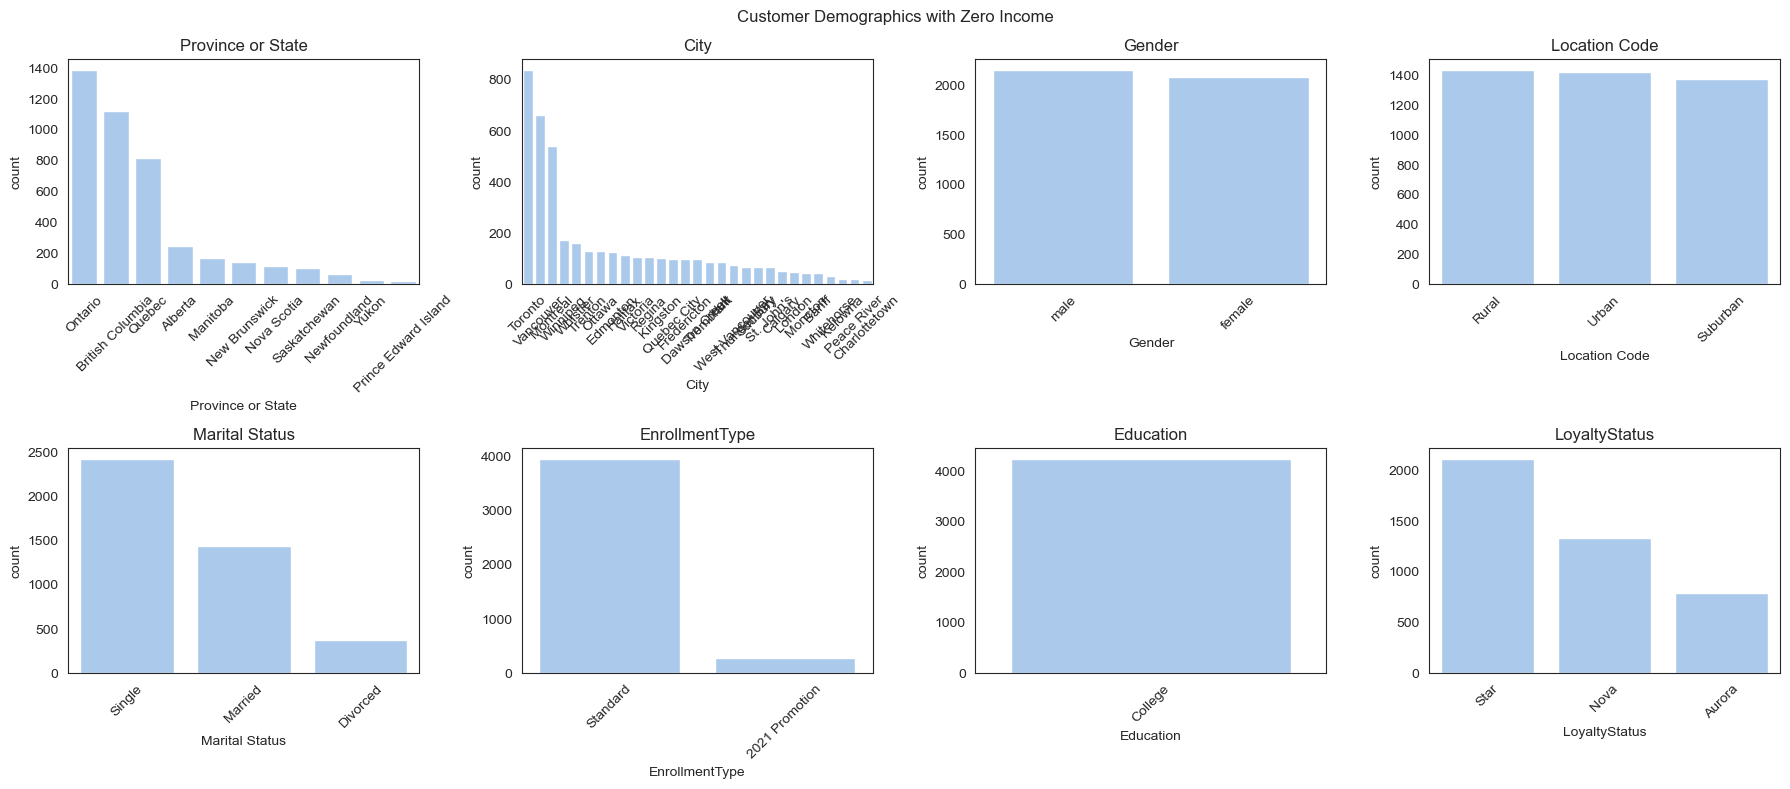

In [ ]:
# Graphs to see what kind of customer has zero income
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axes = axes.flatten()
for i, variable in enumerate(customer_nominal_variables + customer_ordinal_variables):
    sns.countplot(data=customerDB_copy[customerDB_copy["Income"] == 0], x=variable, order=customerDB_copy[customerDB_copy["Income"] == 0][variable].value_counts().index, ax=axes[i])
    axes[i].set_title(variable)
    axes[i].tick_params(axis="x", rotation=45)
plt.suptitle("Customer Demographics with Zero Income")
plt.tight_layout()
plt.show()

We can see here that `Education` is the variable where we only have one category with zero-income value. From a logical point of view, this makes sense, as people who are currently in college (apart from student-workers) don't have a fixed income. We'll replace the zero values with null.

In [ ]:
# Just checking to see how many college-educated customers have non-zero and non-null income
is_college = customerDB_copy["Education"] == "College"
college_count = is_college.sum()
college_zero_income_count = (is_college & (customerDB_copy["Income"] == 0)).sum()
college_null_income_count = (is_college & customerDB_copy["Income"].isna()).sum()
remaining_college_income_count = college_count - (college_zero_income_count + college_null_income_count)
print(remaining_college_income_count)

0


In [ ]:
customerDB_copy.loc[customerDB_copy["Income"] == 0, "Income"] = np.nan

##### Summary Statistics - Cleaned Income

In [ ]:
customerDB_copy["Income"].describe()

count    12499.000000
mean     50549.620210
std      24249.732478
min      10037.000000
25%      28513.000000
50%      48263.000000
75%      70252.500000
max      99981.000000
Name: Income, dtype: float64

Based on the comparison between the mean and the 50th percentile (median), we can expect the distribution to not have many (or any) outliers. It might be slightly skewed to the right, but nothing very drastic.

#### Numerical Data

##### Histograms

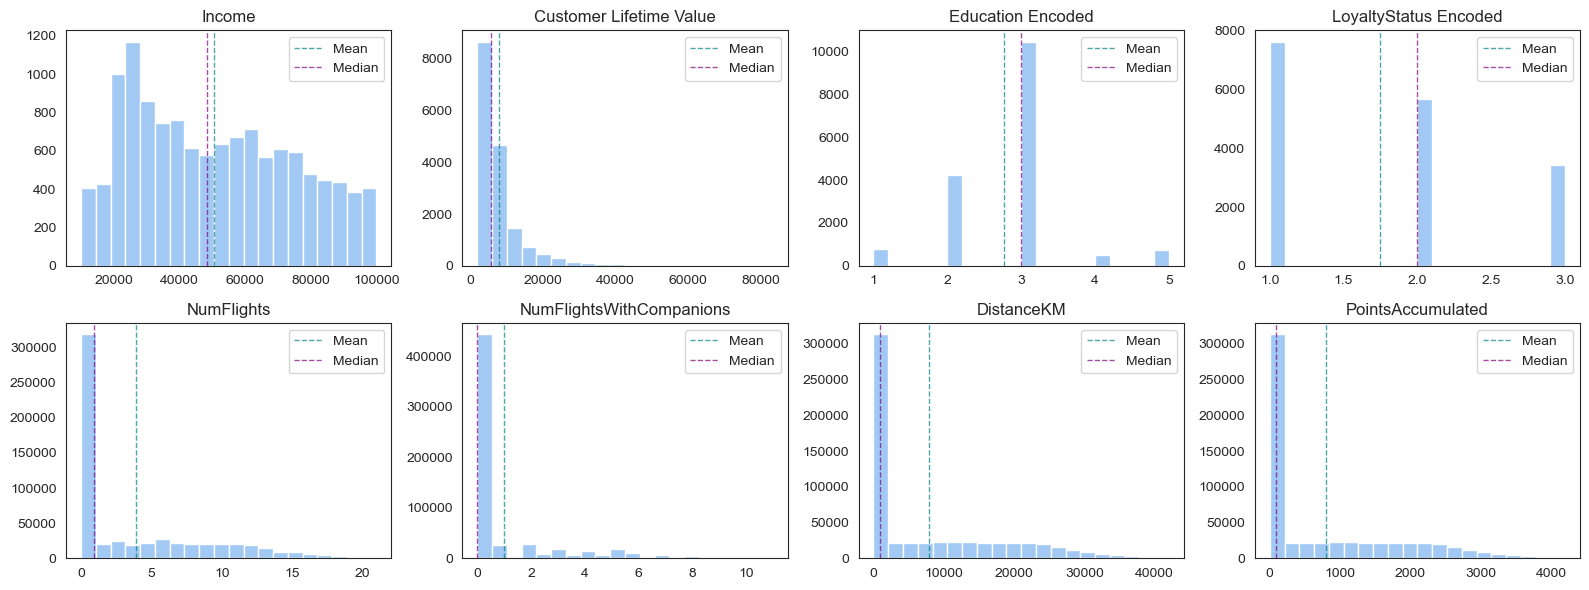

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6))
axes = axes.flatten()
for i, variable in enumerate(customer_numerical_variables + customer_ordinal_variables_encoded + flight_numerical_variables[:-1]):
    if variable in customer_numerical_variables or variable in customer_ordinal_variables_encoded:
        axes[i].hist(customerDB_copy[variable].dropna(), bins=20)
        axes[i].axvline(customerDB_copy[variable].mean(), color="teal", linestyle="dashed", linewidth=1, label="Mean", alpha=0.7)
        axes[i].axvline(customerDB_copy[variable].median(), color="purple", linestyle="dashed", linewidth=1, label="Median", alpha=0.7)
        axes[i].legend()
    else:
        axes[i].hist(flightDB_copy[variable].dropna(), bins=20)
        axes[i].axvline(flightDB_copy[variable].mean(), color="teal", linestyle="dashed", linewidth=1, label="Mean", alpha=0.7)
        axes[i].axvline(flightDB_copy[variable].median(), color="purple", linestyle="dashed", linewidth=1, label="Median", alpha=0.7)
        axes[i].legend()
    axes[i].set_title(variable)
plt.tight_layout()
plt.show()

**Customer DB**

- `Income`: The graph peaks around the mark of $20K–$60K yearly income, being somewhat skewed to the right, as expected from the summary statistics analysis. We can see there is a middle‑income customer base with a slightly smaller subset of high earners.
- `Customer Lifetime Value`: The distribution is highly right‑skewed, concentrated near lower CLV values and with a long right tail. Most customers contribute modestly to company value, while a limited group drives substantially higher returns.
- `Education Encoded`: The distribution is discrete, with a clear concentration around one category level (Bachelor). This suggests that most customers share a similar education background.
- `LoyaltyStatus Encoded`: The histogram shows a near‑uniform spread across loyalty tiers, though slightly denser at lower levels. This implies that the customer base is evenly distributed but leans slightly toward the low‑status tier.

**Flights DB**

While these distributions will give us a first look at the overall flight activity, they aren’t enough on their own to explain customer behavior or seasonal trends. To get meaningful insights, we’ll need to merge the flight data with the customer information and create aggregated features. These steps in the following phase will help us move from general distributions to deeper, time‑based and customer‑specific insights.

For now, we'll do a general analysis of the variables in the flights dataset.


- `NumFlights`: The distribution is heavily right-skewed, with most customers registering zero or very few flights. This suggests a large proportion of infrequent or inactive travelers and a small fraction of frequent flyers.
- `NumFlightsWithCompanions`: A strong spike at zero indicates that most customers usually travel alone or not at all.
- `DistanceKM`: The histogram is right‑skewed, peaking at short‑distance flights with a gradual decline toward long‑distance travel. This suggests that local or domestic trips dominate, while international routes are less common.
- `PointsAccumulated`: Interestingly, the distributions of `DistanceKM` and `PointsAccumulated` look basically identical, differing only in scale. This suggests that the two variables are highly correlated. Customers who travel longer distances tend to accumulate more points. Because of this strong relationship, these features may carry redundant information, and it might make sense to drop one of them later in the analysis to reduce overlap.

##### Box Plots

Box plots are not ideal for discrete or ordinal variables because quartiles and whiskers don’t carry much meaning when the variable only takes a few distinct values. For this reason, we will not include `Education Encoded` and `LoyaltyStatus Encoded` in this visualisation.

Number of outliers in Income: 0
Number of outliers in Customer Lifetime Value: 1485
Number of outliers in NumFlights: 3389
Number of outliers in NumFlightsWithCompanions: 105021
Number of outliers in DistanceKM: 1911
Number of outliers in PointsAccumulated: 1914


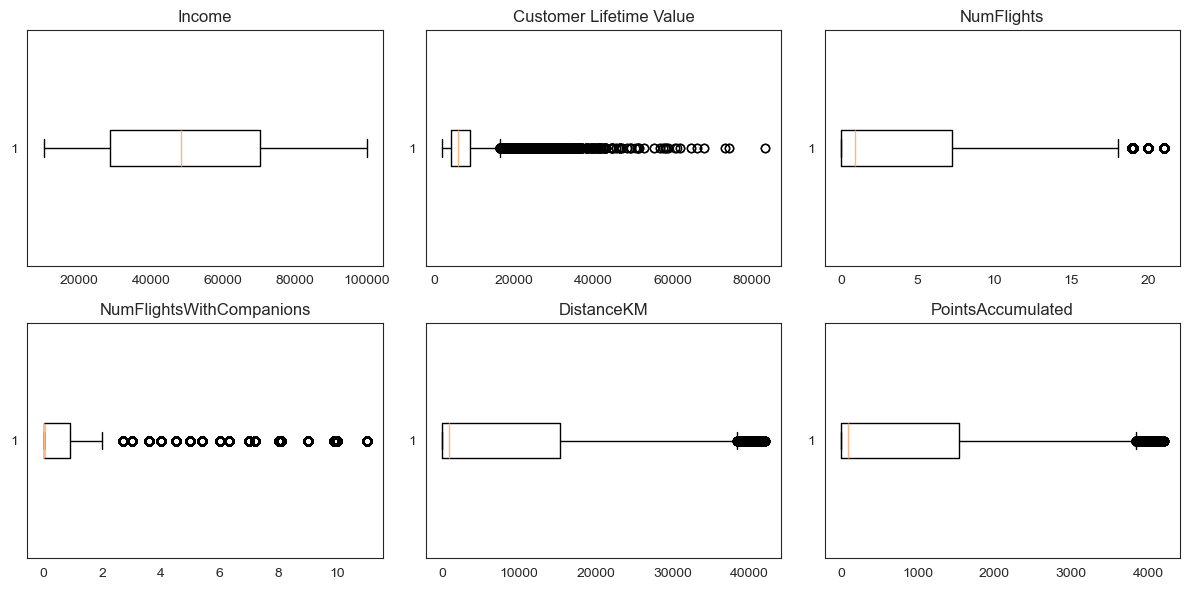

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
axes = axes.flatten()
for i, variable in enumerate(customer_numerical_variables + flight_numerical_variables[:-1]):

    if variable in customer_numerical_variables:
        used_df = customerDB_copy
    else:
        used_df = flightDB_copy

    axes[i].boxplot(used_df[variable].dropna(), vert=False)
    axes[i].set_title(variable)

    Q1 = used_df[variable].quantile(0.25)
    Q3 = used_df[variable].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = used_df[(used_df[variable] < lower_bound) |
                                   (used_df[variable] > upper_bound)]

    print(f"Number of outliers in {variable}:", outliers.shape[0])
plt.tight_layout()
plt.show()

**Customer DB**

- `Income`: The box plot confirms that most incomes cluster in the $20K–$60K range, with no visible outliers. The absence of extreme values suggests the income levels are relatively consistent among customers, reinforcing the idea of a mostly middle‑income population with limited variability.
- `Customer Lifetime Value`: The distribution shows a short box and a long upper whisker filled with outliers, confirming a heavily right‑skewed pattern. Only a handful of customers generate significantly higher lifetime value compared to the rest.

**Flights DB**

- `NumFlights`: The distribution features a moderate spread and a substantial number of outliers (~3,4K) above the upper whisker. This suggests that most customers take few flights per year, while a small portion of highly active travelers fly much more often than average.
- `NumFlightsWithCompanions`: The box plot shows a highly concentrated distribution with an extremely large number of outliers (~105K). At first glance, this suggests that most customers rarely travel with companions while a few do so very frequently. However, it’s important to note that this variable is a subset of NumFlights, so customers who didn’t fly at all will automatically appear with zero companion flights. Therefore, this heavy clustering at zero likely reflects both customers who travel alone and those who simply haven’t flown, rather than a true lack of companion travel among active flyers.
- `DistanceKM`: The plot has a clear right‑skewed shape, showing that while most customers travel shorter distances, a small subset takes very long-distance flights. These outliers probably correspond to premium or business travelers who contribute heavily to overall distance and value metrics.
- `PointsAccumulated`:  As expected, the distribution mirrors the shape of `DistanceKM`, with a long right tail and very similar proportional spread.

#### Categorical Data

##### Bar Plots

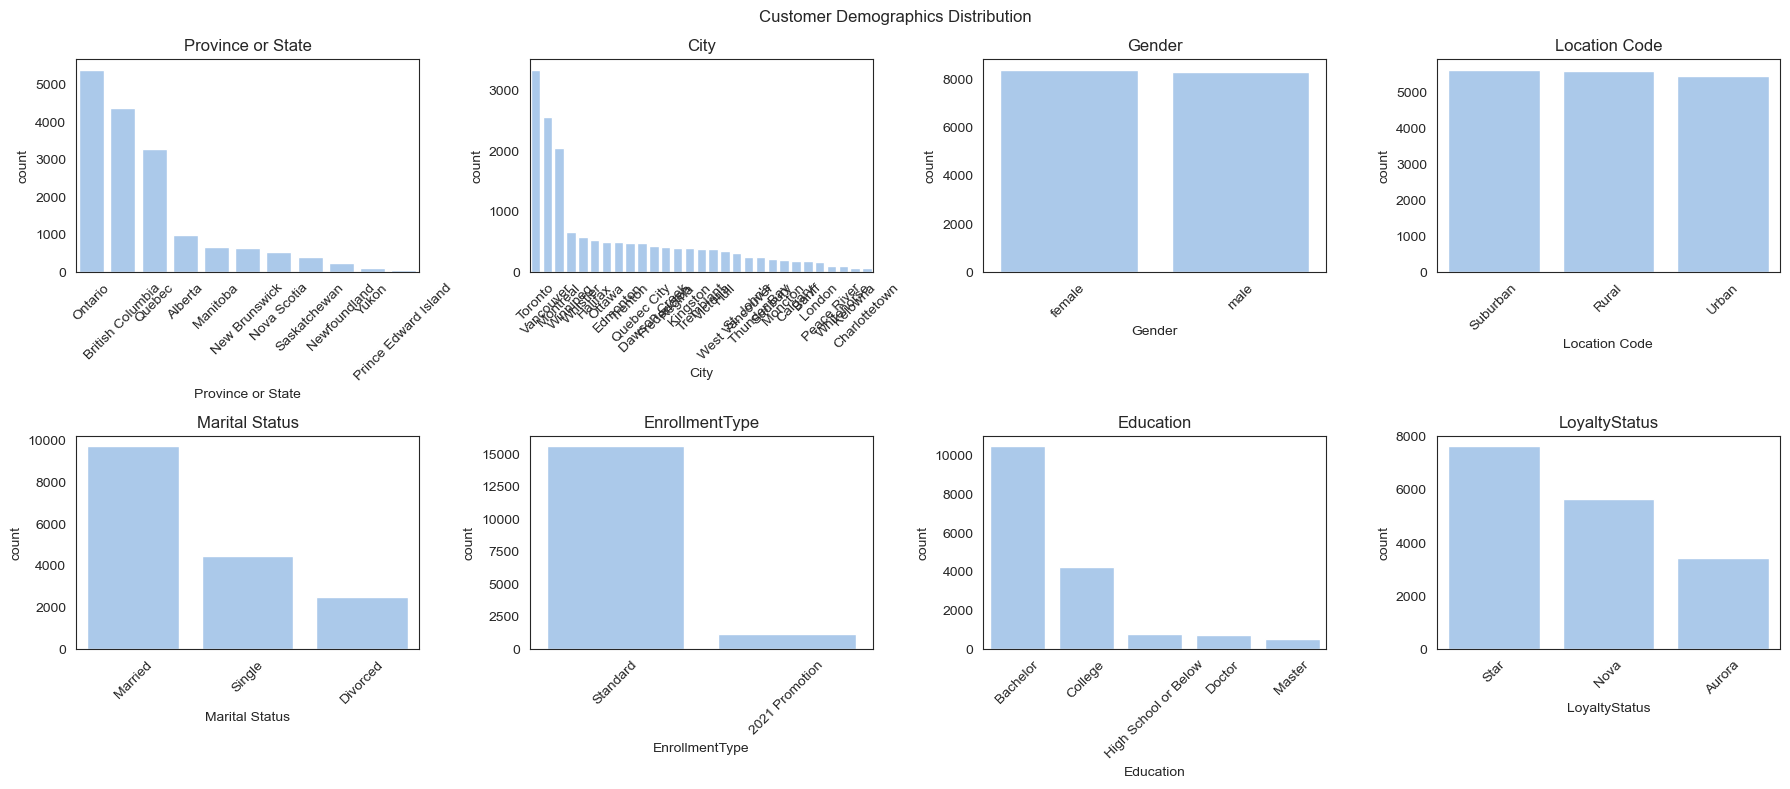

In [ ]:
# for categorical in customer (the ordinal ones as well)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axes = axes.flatten()
for i, variable in enumerate(customer_nominal_variables + customer_ordinal_variables):
    sns.countplot(data=customerDB_copy, x=variable, order=customerDB_copy[variable].value_counts().index, ax=axes[i])
    axes[i].set_title(variable)
    axes[i].tick_params(axis="x", rotation=45)
plt.suptitle("Customer Demographics Distribution")
plt.tight_layout()
plt.show()

`Province or State`, `City` & `Location Code`

The Province/State and City bar plots show that the vast majority of customers come from Ontario, followed by British Columbia and Québec, which are Canada’s most populated and urbanized regions. Correspondingly, the City distribution is dominated by Toronto, Vancouver, and Montreal, with a sharp drop‑off toward smaller cities like Calgary, Edmonton, Winnipeg, and Halifax.

Despite this concentration in large metropolitan areas, the Location Code plot shows that the customer base is almost evenly split among Urban, Suburban, and Rural areas. This balanced distribution suggests that within each major province, customers come from a wide range of environments: large city centers, surrounding commuter towns, and smaller rural communities.

`Gender`

No significant skew or bias appears here, meaning the sample captures a fairly balanced gender distribution.

`Marital Status`

A clear hierarchy emerges here: the majority of customers are Married, followed by Single, then Divorced with the smallest group. Married customers make up nearly half the dataset.

`EnrollmentType`

The Standard enrollment category accounts for almost all customers, while the 2021 Promotion group forms only a small fraction. This suggests that the promotional campaign brought in relatively few new enrollments compared to ongoing standard registrations.

`Education`

Education levels vary strongly, with Bachelor’s degree being the dominant category by far. College follows at about half that count, while High School or Below, Master, and Doctor make up much smaller proportions. This confirms the customer base is generally well‑educated, skewed toward undergraduate degrees.

`LoyaltyStatus`

The loyalty program tiers are also unevenly distributed. Star (the entry‑level tier) has the most customers, followed by Nova, while Aurora (the top tier) has the smallest count. This is an expected pyramid structure typical of loyalty programs.

#### Correlations

##### Numerical & Numerical Data

**Correlation Heatmap**

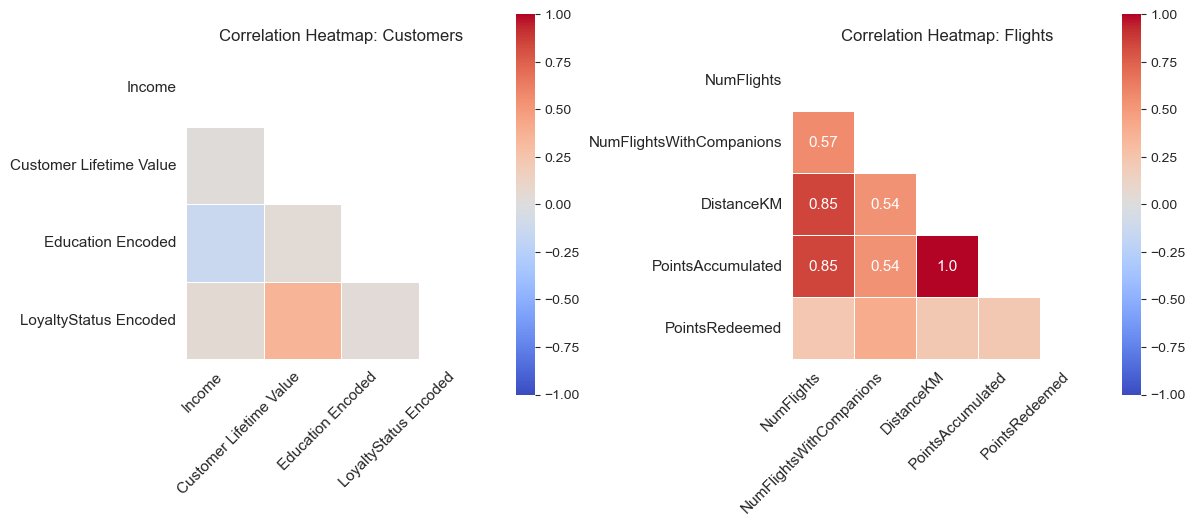

In [ ]:
# We're using Spearman correlation since we have non-normally distributed variables
corr_c = customerDB_copy[customer_numerical_variables + customer_ordinal_variables_encoded].corr(method="spearman")
corr_f = flightDB_copy[flight_numerical_variables].corr(method="spearman")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, (df, name) in zip(axes, zip([corr_c, corr_f], ["Customers", "Flights"], strict=True), strict=True):
    annot = df.round(2).astype(str)
    weak_mask = df.abs() < 0.5
    annot = annot.where(~weak_mask, "")
    mask = np.triu(np.ones_like(df, dtype=bool))
    sns.heatmap(
        df,
        annot=annot,
        mask=mask,
        vmin=-1, vmax=1,
        square=True,
        cmap="coolwarm",
        fmt="s",
        linewidths=.5,
        annot_kws={"size": 11},
        cbar_kws={"shrink": 0.8},
        ax=ax
    )
    ax.set_title(f"Correlation Heatmap: {name}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=11)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)

plt.tight_layout()
plt.show()

The customer-level correlation matrix is essentially empty, showing no strong linear relationship between `Income`, `Customer Lifetime Value`, `Education` and `LoyaltyStatus`. The most important conclusion we can make from this is that a higher annual income / education level / loyalty status does not necessarily translate into a higher total monetary value of the customer relationship. CLV likely depends more on behavioral factors (like engagement or travel frequency) than on income alone.

**`DistanceKM` - `PointsAccumulated`: 1.0 Correlation**

The correlation coefficient is 1.0, indicating a perfect linear relationship. As customers travel longer distances, they earn proportionally more loyalty points. This perfect correlation, along with the basically identical shapes of their histograms and boxplots, shows that one of them is redundant. Therefore, we’ll drop `PointsAccumulated` and keep `DistanceKM`, since distance is a more direct and interpretable metric of customer travel.

**`DistanceKM` - `NumFlights`: 0.85 Correlation**

While these aren’t identical measures, they’re closely aligned. Number of flights captures frequency and DistanceKM captures intensity or scale of travel. It makes sense that a customer with more flights has a higher total travelled distance.

**`NumFlights` - `NumFlightsWithCompanions`: 0.57 Correlation**

This relationship makes intuitive sense: customers who fly more often are somewhat more likely to have flown with companions at least occasionally.

**`Points Redeemed`**

This variable shows weak correlations with all other flight features. That means the amount of loyalty points customers spend isn’t tightly linked to their number of flights, distance traveled, or accumulated points. Points redemption likely depends on personal behaviors, timing, or special offers rather than direct flying frequency.

In [ ]:
flightDB_copy.drop(columns=["PointsAccumulated"], inplace=True)
flight_numerical_variables.remove("PointsAccumulated")
flightDB_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 602532 entries, 405624 to 169662
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Loyalty#                  602532 non-null  int64  
 1   Year                      602532 non-null  int64  
 2   Month                     602532 non-null  int64  
 3   NumFlights                602532 non-null  float64
 4   NumFlightsWithCompanions  602532 non-null  float64
 5   DistanceKM                602532 non-null  float64
 6   PointsRedeemed            602532 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 36.8 MB


**Hexbin Maps**

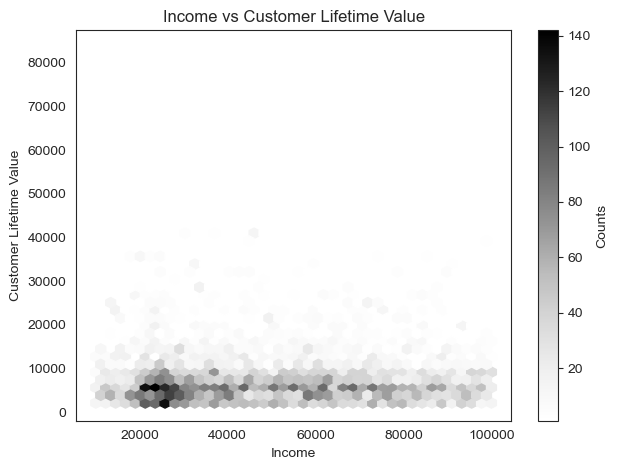

In [ ]:
plt.hexbin(customerDB_copy["Income"], customerDB_copy["Customer Lifetime Value"], gridsize=40, cmap="Greys", mincnt=1)
plt.xlabel("Income"); plt.ylabel("Customer Lifetime Value")
plt.title("Income vs Customer Lifetime Value")
plt.colorbar(label="Counts")
plt.tight_layout()
plt.show()

The first hexbin plot shows that most data points are concentrated in the lower band of `Customer Lifetime Value` (CLV), particularly between $0 and $10K, and in the income range of roughly $20K to $60K. The density darkens sharply in that zone, while it quickly fades toward higher values of either axis. There’s no visible upward trend or gradient, confirming that `Income` has little to no linear relationship with `Customer Lifetime Value`. This supports the earlier correlation heatmap finding that income and CLV are largely independent.

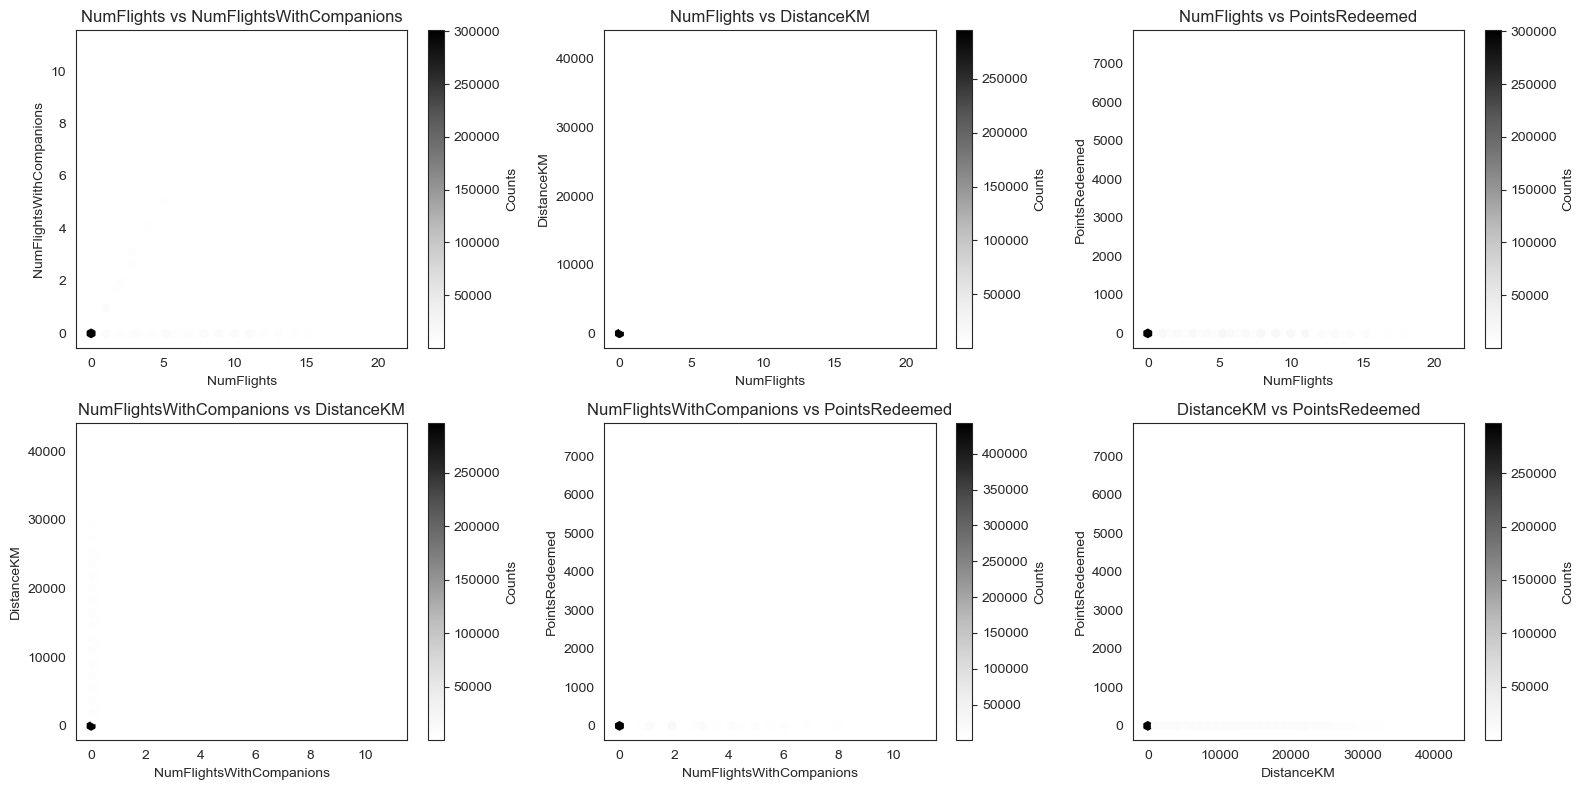

In [ ]:
flight_pairs = list(itertools.combinations(flight_numerical_variables, 2))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axes = axes.flatten()

# Plot flight variable pairs using paired dropna so lengths match
for i, (v1, v2) in enumerate(flight_pairs):
    ax = axes[i]
    df_f = flightDB_copy[[v1, v2]].dropna()
    if not df_f.empty:
        hb = ax.hexbin(df_f[v1], df_f[v2], gridsize=40, cmap="Greys", mincnt=1)
        ax.set_xlabel(v1); ax.set_ylabel(v2)
        ax.set_title(f"{v1} vs {v2}")
        plt.colorbar(hb, ax=ax, label="Counts")

plt.tight_layout()
plt.show()

These plots are completely dominated by zeros because a large part of the dataset corresponds to customers who didn’t fly during the month. When `NumFlights` is zero, all other flight‑related variables are automatically zero as well. This creates an enormous cluster in the bottom‑left corner of every hexbin and hides any meaningful relationships among active flyers.

To better explore how these variables relate to each other when actual flights occur, we’ll remove the rows where `NumFlights` = 0. That way, the plots focus only on customers who flew, so we can clearly see patterns like how total distance grows with flight count or how companion flights vary among active travelers.

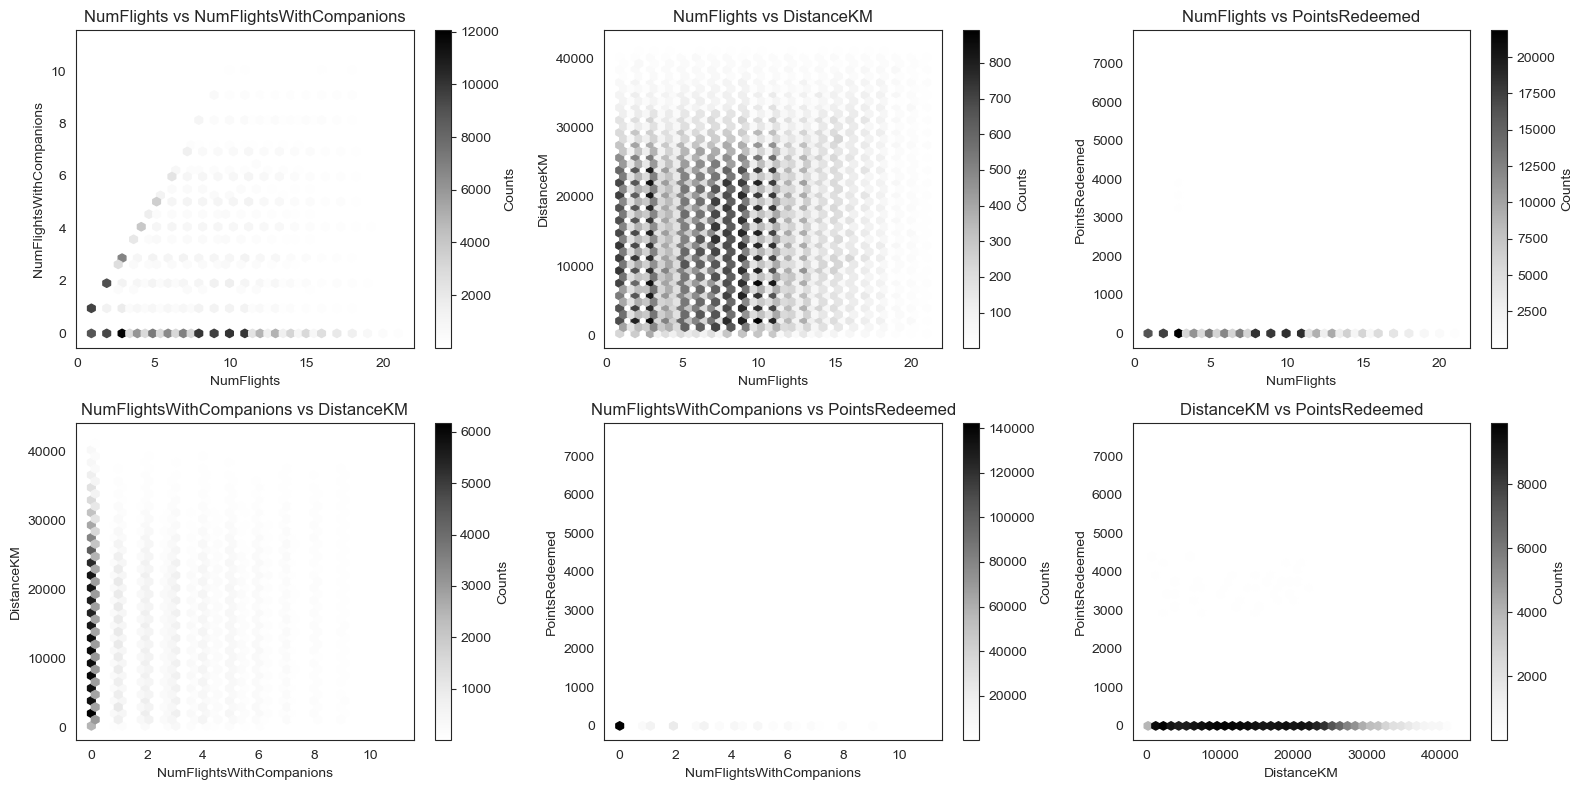

In [ ]:
flight_pairs = list(itertools.combinations(flight_numerical_variables, 2))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axes = axes.flatten()

# filter out rows where NumFlights is zero
flight_nonzero = flightDB_copy[flightDB_copy["NumFlights"] != 0]

# Plot flight variable pairs using paired dropna so lengths match
for i, (v1, v2) in enumerate(flight_pairs):
    ax = axes[i]
    df_f = flight_nonzero[[v1, v2]].dropna()
    if not df_f.empty:
        hb = ax.hexbin(df_f[v1], df_f[v2], gridsize=40, cmap="Greys", mincnt=1)
        ax.set_xlabel(v1); ax.set_ylabel(v2)
        ax.set_title(f"{v1} vs {v2}")
        plt.colorbar(hb, ax=ax, label="Counts")

plt.tight_layout()
plt.show()

`NumFlights` vs `NumFlightsWithCompanions`

This plot shows a clear upward diagonal pattern. As the number of flights increases, the number of flights with companions also tends to rise.
The darker concentrations along the bottom-left portion and gradually fading towards the top-right indicate that most customers travel alone or with companions only on some flights. Very few customers travel with companions on every flight. Moreover, the thick line at the bottom shows that regardless of total flights, a large majority never travel with companions.
The triangular clustering (bounded by the diagonal) simply reflects that the number of companion flights can never exceed total flights, which confirms data consistency.

`NumFlights` vs `DistanceKM`

The hexbin plot shows vertical bands because `NumFlights` is a discrete variable with integer values. Even though it doesn't look like a clean diagonal trend, the Spearman correlation (~0.85) confirms a strong positive relationship. Customers who take more flights usually travel longer total distances. The spread within each flight count just shows variation in trip length, with some people taking a few long-haul flights and others taking many short ones.

`NumFlights` vs `PointsRedeemed`

Most of the density sits right along the bottom edge, showing that very few customers redeem points in a given month, no matter how many flights they take. There’s no visible upward trend, which matches the weak correlation between these variables.

`NumFlightsWithCompanions` vs `DistanceKM`

There’s a slight upward pattern, meaning that customers with more companion flights usually travel longer total distances, but most activity still happens within the first few companion flights. The clustering near the bottom-left corner shows that flying alone or only once or twice with companions is much more common.

`NumFlightsWithCompanions` vs `PointsRedeemed`

Almost all points fall near zero on the y-axis. Even among people who fly with companions, point redemptions are rare, and there’s no clear relationship between the two. This again confirms that redeeming points isn’t tied to travel behavior.

`DistanceKM` vs `PointsRedeemed`

All the density clusters tightly along the bottom, showing that traveling longer distances doesn’t lead to more points redeemed. Most customers earn points when traveling but don’t use them often, suggesting redemption behavior is independent of distance traveled.

**Violin Plots** - Continuous & Discrete

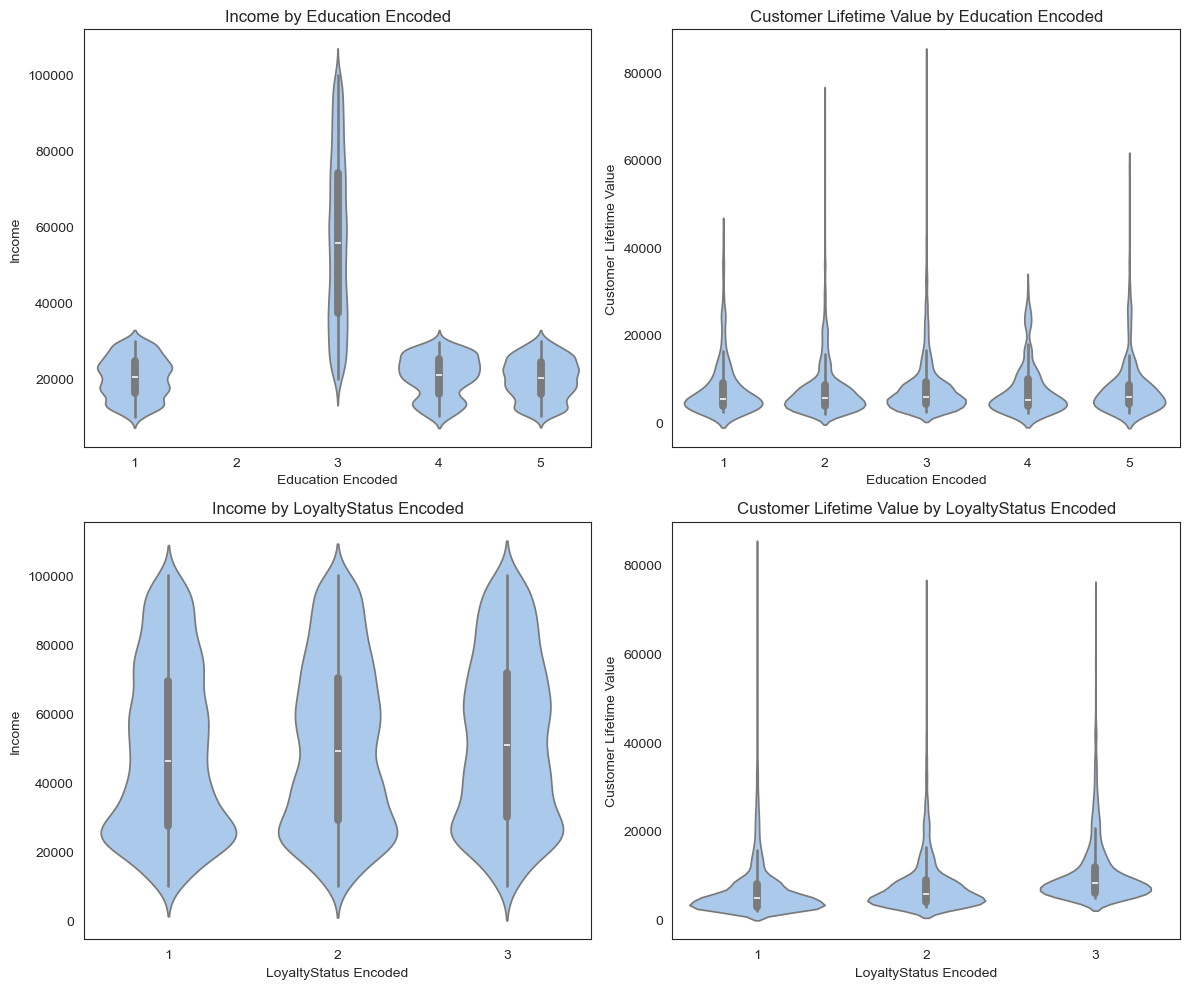

In [ ]:
# violin plots for education and loyalty status encoded vs income and clv
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()
for i, variable in enumerate(customer_ordinal_variables_encoded):
    sns.violinplot(data=customerDB_copy, x=variable, y="Income", ax=axes[i*2])
    axes[i*2].set_title(f"Income by {variable}")
    sns.violinplot(data=customerDB_copy, x=variable, y="Customer Lifetime Value", ax=axes[i*2 + 1])
    axes[i*2 + 1].set_title(f"Customer Lifetime Value by {variable}")
plt.tight_layout()
plt.show()

`Income` by `Education Encoded`

The income distribution looks pretty flat across most education levels except for category 3, which stands out with noticeably higher values and a wider spread. That group includes most of the top‑income customers, while the others cluster tightly around the lower range. There’s no smooth upward or downward trend across education levels, so income isn’t increasing consistently with education like we might expect, being mainly driven by that one dominant category.

`Customer Lifetime Value` by `Education Encoded`

CLV distributions are almost the same across education groups. All of them are right‑skewed, with most customers having relatively low CLV and a few long‑tail high values. There’s no clear separation between categories, suggesting that education level doesn’t have much impact on overall customer value.

`Income` by `LoyaltyStatus Encoded`

The shapes for all loyalty tiers are almost identical, centered around a similar income range. There’s no visible shift or widening, meaning higher loyalty doesn’t necessarily correspond to higher income. Customers across all loyalty levels share a similar income profile.

`Customer Lifetime Value` by `LoyaltyStatus Encoded`

All three loyalty groups show very similar CLV distributions: mostly low values with a long tail of high ones. There’s no clear increase in CLV with higher loyalty status, which lines up with the earlier correlation results showing weak or no relationship between these factors.

##### Categorical & Categorical Data

**Stacked Bar Plots**

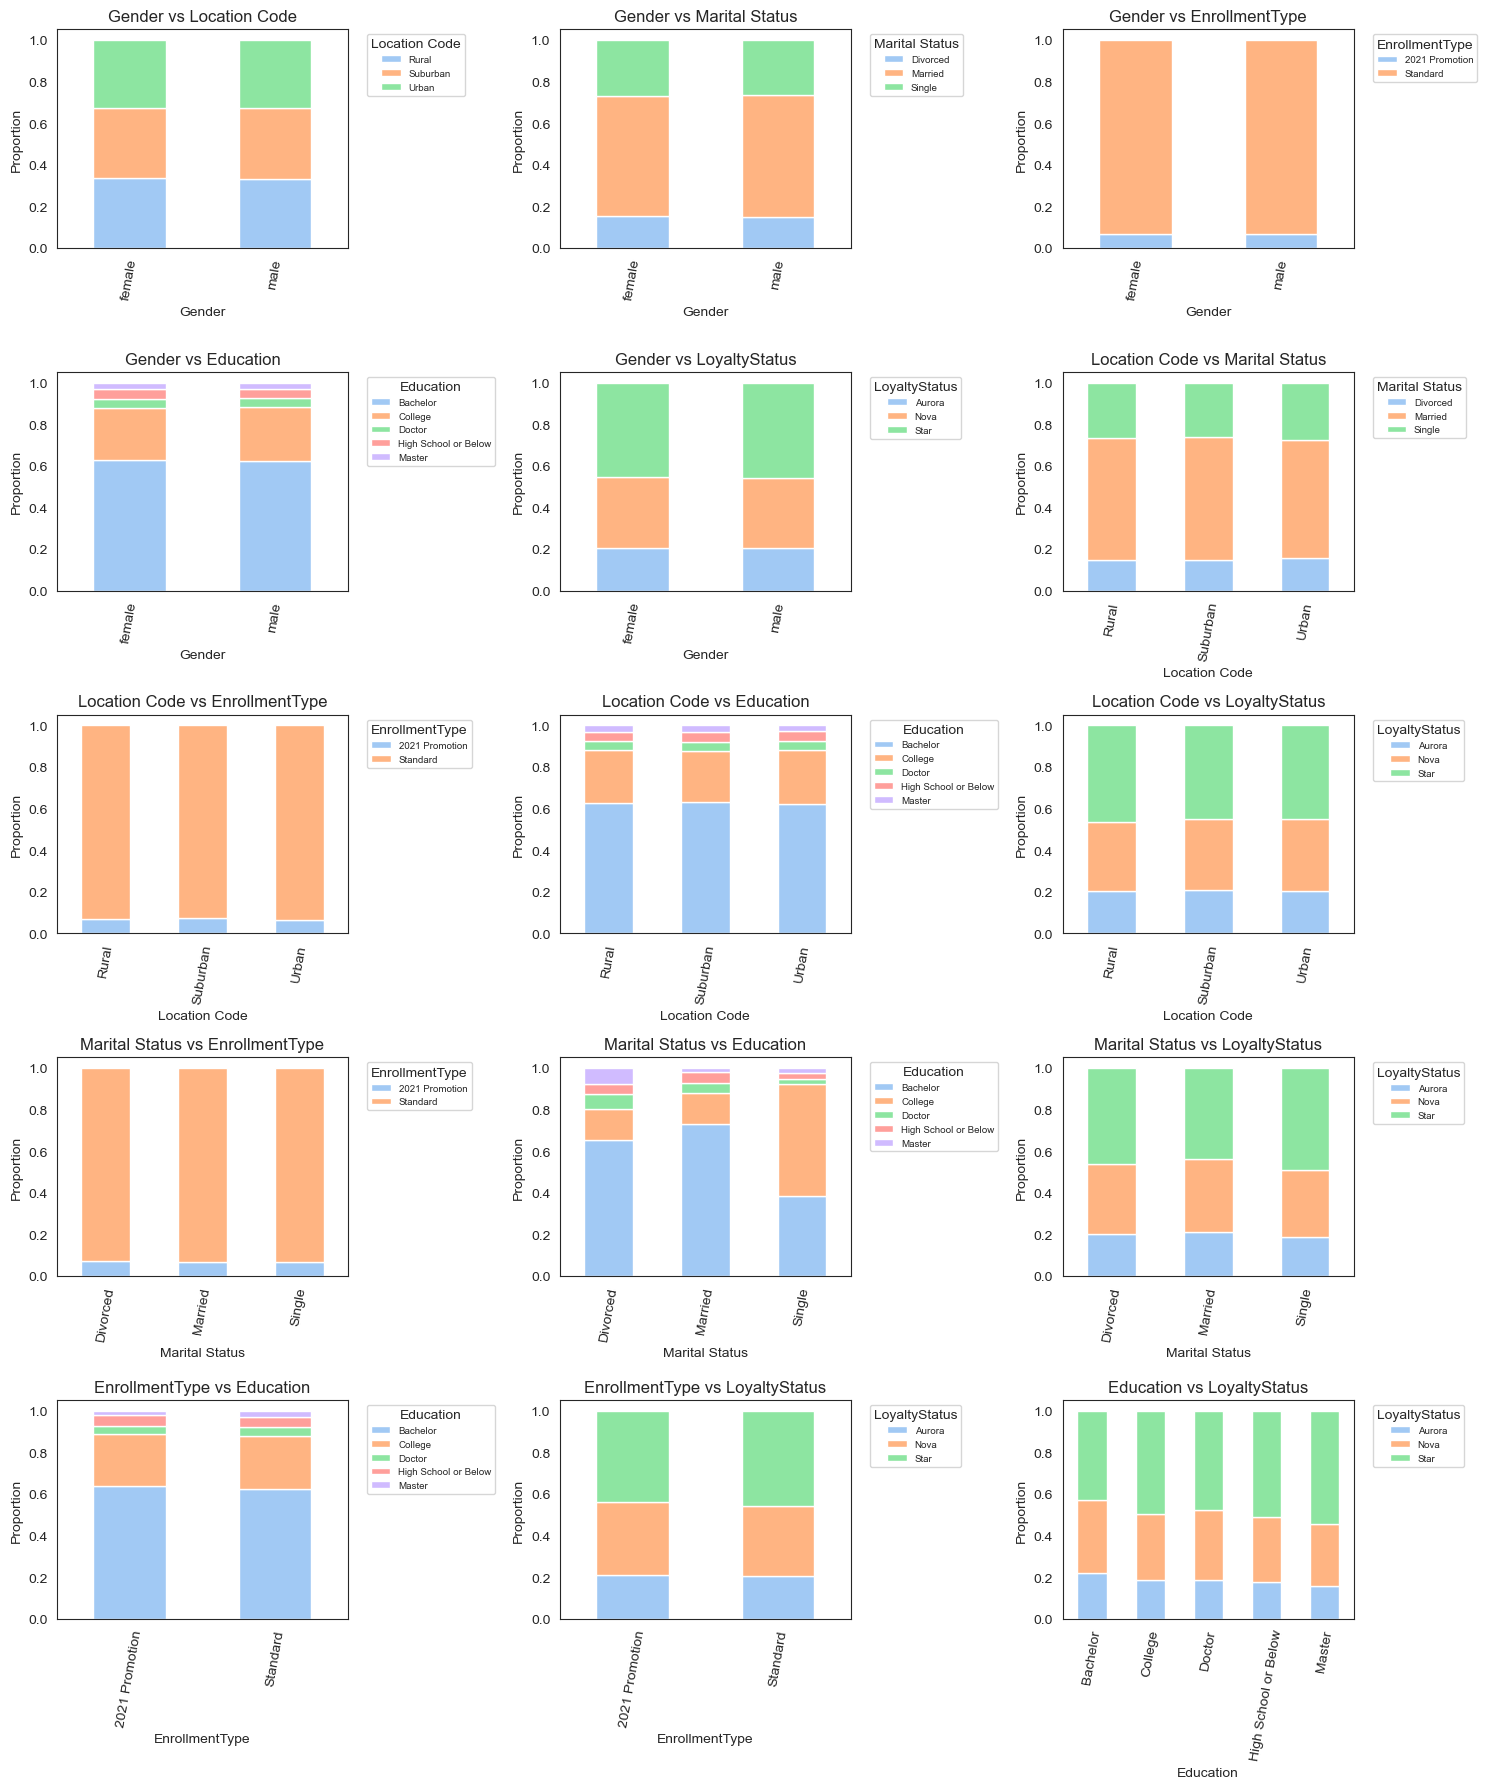

In [ ]:
# Stacked bar plots for categorical vs categorical correlations
combinations = list(itertools.combinations(["Gender", "Location Code", "Marital Status", "EnrollmentType"] + customer_ordinal_variables, 2))
cols = 3
rows = math.ceil(len(combinations) / cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(rows*3, cols*6))
axes = axes.flatten()
for i, (cat_var1, cat_var2) in enumerate(combinations):
    ax = axes[i]
    cross_tab = pd.crosstab(customerDB_copy[cat_var1], customerDB_copy[cat_var2], normalize="index")
    cross_tab.plot(kind="bar", stacked=True, ax=ax, legend=False)
    ax.set_title(f"{cat_var1} vs {cat_var2}")
    ax.set_ylabel("Proportion")
    ax.tick_params(axis="x", rotation=80)
    ax.legend(
        title=cat_var2,
        loc="upper left",
        bbox_to_anchor=(1.05, 1),  # move slightly to the right
        fontsize=7
    )
plt.tight_layout()
plt.show()

In the `Marital Status` vs `Education` plot, there are small but clear differences between groups. Singles have a much larger share of the College category and a noticeably smaller share of Bachelor degrees compared to married or divorced customers. Married and divorced groups look very similar to each other, both dominated by the Bachelor group with small shares across the other education levels. This suggests that education levels are somewhat different by marital status. Singles are probably younger people, with more “in‑progress” or mid‑tier education, while married and divorced customers seem to have slightly more completed higher degrees.

In the `Education` vs `LoyaltyStatus` plot, the distributions across education levels are very similar overall. The Aurora (highest) tier and the other two levels (Star and Nova) maintain roughly consistent proportions across all education categories. The only small difference is that customers with a Master’s degree have a slightly lower share of Aurora and a slightly higher share of Star, but the gap is minimal. This suggests that loyalty status doesn’t depend much on education and higher education doesn’t necessarily mean higher loyalty.

The rest of the categorical combinations in this batch don’t show any meaningful differences. Their proportions stay consistent across groups, meaning most demographic variables have little or no observable effect on program‑related attributes.

##### Numerical & Categorical Data

**Histogram w/ Colour Overlay**

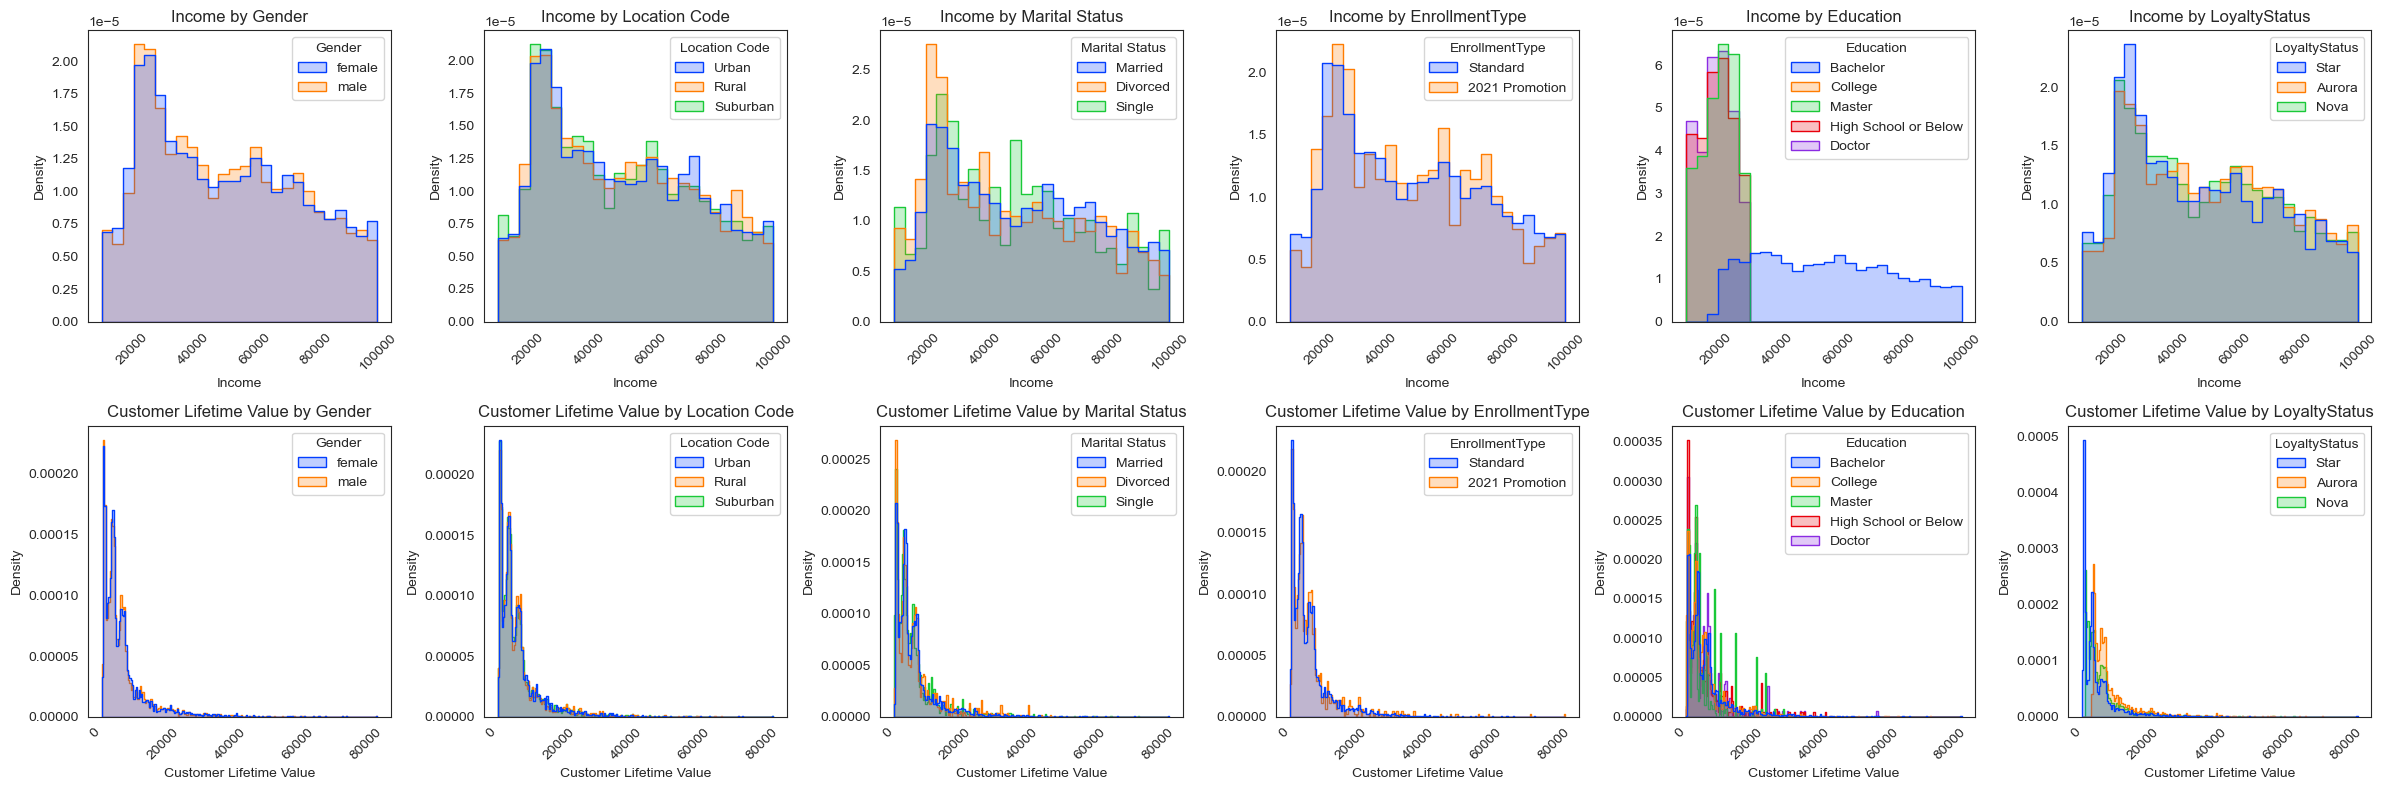

In [ ]:
sns.set_palette("bright")
colour_vars = ["Gender", "Location Code", "Marital Status", "EnrollmentType"] + customer_ordinal_variables

rows = len(customer_numerical_variables)
cols = len(colour_vars)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*4, rows*4))
axes = axes.flatten()

for j, num_var in enumerate(customer_numerical_variables):
    for i, variable in enumerate(colour_vars):
        idx = j * len(colour_vars) + i
        sns.histplot(
            data=customerDB_copy,
            x=num_var,
            hue=variable,
            element="step",
            stat="density",
            common_norm=False,
            ax=axes[idx]
        )
        axes[idx].set_title(f"{num_var} by {variable}")
        axes[idx].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

Bachelor‑degree customers clearly have higher and more diverse income levels, while all other education groups are concentrated at the lower end of the income range. This makes education (specifically having a Bachelor’s degree) the only variable showing a meaningful separation in income distribution. This trend confirms what was already observed in the violin plots, where treating the ordinal education data as discrete (through encoding) also highlighted the Bachelor group as the main driver of income variability.

The remaining plots display minimal differences in their distributions. Income densities for gender, location code, marital status, enrollment type, and loyalty status all overlap almost perfectly, indicating that these demographic and program categories have no major influence on income. Likewise, distributions of customer lifetime value are nearly identical across all categorical variables (skewed heavily toward lower values with long right tails) showing that CLV is unaffected by demographic factors or program segment.

### 4.5. <a id="4_5">Feature Engineering</a>

#### New Features

To merge the two datasets, we will engineer the following variables into the CustomerDB:
- `FlightsTotal`, `DistanceKM`, `FlightsTotalAccompanied`
- `KMPerFlight`: Could help identify short‑haul vs long‑haul frequent flyers.
- `FlightsRatioAccompanied`: The proportion of accompanied flights relative to the total, providing a normalised behavioral indicator.
- `DistanceRatioRedeemedPoints`: Shows how often customers redeem points relative to their activity. 
- `Flights2019`, `Flights2020` & `Flights2021`: Capture annual travel frequency and allow for time‑based behavioural analysis. They help identify year‑over‑year changes, such as the impact of events or promotions (e.g., the 2021 enrollment campaign). Comparing across years enables growth trend features and temporal modeling.
- `FlightsGrowth2020vs2019` & `FlightsGrowth2021vs2020`: Quantify the relative change in activity between consecutive years. We will see whether a customer is becoming more or less engaged with the airline over time, which can be predictive of future loyalty.
- `FlightsWinter`, `FlightsSpring`, `FlightsSummer` & `FlightsAutumn` (total and by year): Group flights by seasonal periods to capture traveling preferences and seasonality patterns.
- `FlightsJan`, `FlightsFeb`, ..., `FlightsNov` & `FlightsDec` (total and by year): They’re useful for identifying peak or inactive months for customers and for visualizing year‑round engagement patterns. These also feed into other metrics.
- `MonthlyFlightVariance`: Measures how consistent or irregular a customer’s flight activity is across months. A low variance signifies steady travel habits, while a high variance indicates seasonal or irregular behavior.
- `CLVperFlight`: Indicates whether frequent travelers generate proportionally higher CLV.
- `CLVperPointsRedeemed`: Relates lifetime value to redemption behavior.

In [ ]:
pd.set_option("display.max_columns", None)

new_customer_variables = []
month_variables = []

customer_numerical_variables.extend(var for var in ["FlightsTotal", "DistanceKM", "KMPerFlight", "FlightsRatioAccompanied", "DistanceRatioRedeemedPoints",
                                     "FlightsGrowth2020vs2019%", "FlightsGrowth2021vs2020%", "MonthlyFlightVariance", "CLVperFlight", "CLVperPointsRedeemed"] if var not in customer_numerical_variables)
new_customer_variables.extend(var for var in ["FlightsTotal", "DistanceKM", "KMPerFlight", "FlightsRatioAccompanied", "DistanceRatioRedeemedPoints",
                                     "FlightsGrowth2020vs2019%", "FlightsGrowth2021vs2020%", "MonthlyFlightVariance", "CLVperFlight", "CLVperPointsRedeemed"] if var not in new_customer_variables)

customerDB_copy["FlightsTotal"] = flightDB_copy.groupby("Loyalty#")["NumFlights"].sum().round().astype(int)
customerDB_copy["DistanceKM"] = flightDB_copy.groupby("Loyalty#")["DistanceKM"].sum().round().astype(int)
customerDB_copy["KMPerFlight"] = (customerDB_copy["DistanceKM"] / customerDB_copy["FlightsTotal"].replace(0, np.nan)).fillna(0).round(2)
customerDB_copy["FlightsRatioAccompanied"] = (flightDB_copy.groupby("Loyalty#")["NumFlightsWithCompanions"].sum() / customerDB_copy["FlightsTotal"]).round(2)
customerDB_copy["DistanceRatioRedeemedPoints"] = (flightDB_copy.groupby("Loyalty#")["PointsRedeemed"].sum() / customerDB_copy["DistanceKM"]).round(2)

for year in [2019, 2020, 2021]:
    customerDB_copy[f"Flights{year}"] = flightDB_copy[flightDB_copy["Year"] == year].groupby("Loyalty#")["NumFlights"].sum().round().astype(int)
    if f"Flights{year}" not in customer_numerical_variables: customer_numerical_variables.append(f"Flights{year}")
    if f"Flights{year}" not in new_customer_variables: new_customer_variables.append(f"Flights{year}")
    for season, months in zip(["Winter", "Spring", "Summer", "Autumn"], [[12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]], strict=True):
        if f"Flights{season}" not in customerDB_copy.columns:
            customerDB_copy[f"Flights{season}"] = flightDB_copy[flightDB_copy["Month"].isin(months)].groupby("Loyalty#")["NumFlights"].sum().round().astype(int)
            if f"Flights{season}" not in customer_numerical_variables: customer_numerical_variables.append(f"Flights{season}")
            if f"Flights{season}" not in new_customer_variables: new_customer_variables.append(f"Flights{season}")
        customerDB_copy[f"Flights{season}{year}"] = flightDB_copy[(flightDB_copy["Year"] == year) & (flightDB_copy["Month"].isin(months))].groupby("Loyalty#")["NumFlights"].sum().round().astype(int)
        if f"Flights{season}{year}" not in customer_numerical_variables: customer_numerical_variables.append(f"Flights{season}{year}")
        if f"Flights{season}{year}" not in new_customer_variables: new_customer_variables.append(f"Flights{season}{year}")
    for month_name, month in zip(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], range(1, 13), strict=True):
        if f"Flights{month_name}{year}" not in customerDB_copy.columns:
            customerDB_copy[f"Flights{month_name}"] = flightDB_copy[flightDB_copy["Month"] == month].groupby("Loyalty#")["NumFlights"].sum().round().astype(int)
            if f"Flights{month_name}" not in customer_numerical_variables: customer_numerical_variables.append(f"Flights{month_name}")
            if f"Flights{month_name}" not in new_customer_variables: new_customer_variables.append(f"Flights{month_name}")
            if f"Flights{month_name}" not in month_variables: month_variables.append(f"Flights{month_name}")
        customerDB_copy[f"Flights{month_name}{year}"] = flightDB_copy[(flightDB_copy["Year"] == year) & (flightDB_copy["Month"] == month)].groupby("Loyalty#")["NumFlights"].sum().round().astype(int)
        if f"Flights{month_name}{year}" not in customer_numerical_variables: customer_numerical_variables.append(f"Flights{month_name}{year}")
        if f"Flights{month_name}{year}" not in new_customer_variables: new_customer_variables.append(f"Flights{month_name}{year}")
        if f"Flights{month_name}{year}" not in month_variables: month_variables.append(f"Flights{month_name}{year}")

customerDB_copy["FlightsGrowth2020vs2019%"] = (((customerDB_copy["Flights2020"] - customerDB_copy["Flights2019"]) / customerDB_copy["Flights2019"].replace(0, np.nan))*100).fillna(0).round(2)
customerDB_copy["FlightsGrowth2021vs2020%"] = (((customerDB_copy["Flights2021"] - customerDB_copy["Flights2020"]) / customerDB_copy["Flights2020"].replace(0, np.nan))*100).fillna(0).round(2)

customerDB_copy["MonthlyFlightVariance"] = flightDB_copy.groupby(["Loyalty#", "Year", "Month"])["NumFlights"].sum().groupby("Loyalty#").var()

customerDB_copy["CLVperFlight"] = (customerDB_copy["Customer Lifetime Value"] /customerDB_copy["FlightsTotal"].replace(0, np.nan)).fillna(0).round(2)

customerDB_copy["CLVperPointsRedeemed"] = (customerDB_copy["Customer Lifetime Value"] / flightDB_copy.groupby("Loyalty#")["PointsRedeemed"].sum().replace(0, np.nan)).fillna(0).round(2)

customerDB_copy.head()

,Province or State,City,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,Education Encoded,LoyaltyStatus Encoded,FlightsTotal,DistanceKM,KMPerFlight,FlightsRatioAccompanied,DistanceRatioRedeemedPoints,Flights2019,FlightsWinter,FlightsWinter2019,FlightsSpring,FlightsSpring2019,FlightsSummer,FlightsSummer2019,FlightsAutumn,FlightsAutumn2019,FlightsJan,FlightsJan2019,FlightsFeb,FlightsFeb2019,FlightsMar,FlightsMar2019,FlightsApr,FlightsApr2019,FlightsMay,FlightsMay2019,FlightsJun,FlightsJun2019,FlightsJul,FlightsJul2019,FlightsAug,FlightsAug2019,FlightsSep,FlightsSep2019,FlightsOct,FlightsOct2019,FlightsNov,FlightsNov2019,FlightsDec,FlightsDec2019,Flights2020,FlightsWinter2020,FlightsSpring2020,FlightsSummer2020,FlightsAutumn2020,FlightsJan2020,FlightsFeb2020,FlightsMar2020,FlightsApr2020,FlightsMay2020,FlightsJun2020,FlightsJul2020,FlightsAug2020,FlightsSep2020,FlightsOct2020,FlightsNov2020,FlightsDec2020,Flights2021,FlightsWinter2021,FlightsSpring2021,FlightsSummer2021,FlightsAutumn2021,FlightsJan2021,FlightsFeb2021,FlightsMar2021,FlightsApr2021,FlightsMay2021,FlightsJun2021,FlightsJul2021,FlightsAug2021,FlightsSep2021,FlightsOct2021,FlightsNov2021,FlightsDec2021,FlightsGrowth2020vs2019%,FlightsGrowth2021vs2020%,MonthlyFlightVariance,CLVperFlight,CLVperPointsRedeemed
Loyalty#,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
480934,Ontario,Toronto,female,Bachelor,Urban,70146.0,Married,Star,2019-02-15,NaT,3839.14,Standard,3,1,190,507055,2668.71,0.30,0.03,58,18,5,47,12,85,31,40,10,2,0,8,3,2,0,13,0,32,12,24,11,30,7,31,13,17,2,8,1,15,7,9,3,64,6,13,34,11,0,3,0,0,13,12,8,14,2,1,8,3,68,7,22,20,19,2,2,2,13,7,1,15,4,13,6,0,3,10.34,6.25,25.201143,20.21,0.28
549612,Alberta,Edmonton,male,College,Rural,NaN,Divorced,Star,2019-03-09,NaT,3839.61,Standard,2,1,279,426827,1529.85,0.12,0.05,89,52,16,84,27,84,25,59,21,24,8,17,8,32,13,10,0,42,14,12,0,36,11,36,14,10,0,28,11,21,10,11,0,99,18,30,28,23,9,9,14,0,16,0,12,16,0,12,11,0,91,18,27,31,15,7,0,5,10,12,12,13,6,10,5,0,11,11.24,-8.08,30.405421,13.76,0.17
429460,British Columbia,Vancouver,male,College,Urban,NaN,Single,Star,2017-07-14,2021-01-08,3839.75,Standard,2,1,120,238376,1986.47,0.33,0.02,54,31,12,38,18,21,10,30,14,21,7,8,4,15,7,0,0,23,11,0,0,0,0,21,10,15,7,0,0,15,7,2,1,60,13,20,11,16,8,4,8,0,12,0,0,11,8,0,8,1,6,6,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,11.11,-90.00,17.422286,32.00,0.70
608370,Ontario,Toronto,male,College,Suburban,NaN,Single,Star,2016-02-17,NaT,3839.75,Standard,2,1,196,386029,1969.54,0.30,0.04,73,48,14,68,30,36,14,43,15,11,4,21,6,30,14,13,6,24,10,36,14,0,0,0,0,19,9,22,5,2,1,16,4,81,16,33,15,17,4,7,15,7,11,15,0,0,10,6,1,5,42,18,5,8,11,3,8,2,0,3,8,0,0,0,11,0,7,10.96,-48.15,22.487071,19.59,0.24
530508,Quebec,Hull,male,Bachelor,Suburban,97832.0,Married,Star,2017-10-25,NaT,3842.79,2021 Promotion,3,1,171,369243,2159.32,0.37,0.00,39,37,9,28,6,73,15,32,8,0,0,22,9,4,0,0,0,24,6,15,1,21,2,38,13,8,2,0,0,24,6,15,0,43,10,7,17,9,0,10,0,0,7,1,2,14,2,0,7,0,89,18,15,41,15,0,3,4,0,11,13,17,11,4,0,11,15,10.26,106.98,28.772214,22.47,0.00


#### Selecting Granularity

Now that we have created these features, we'll do a quick analysis just to see if there's a need to keep this level of granularity.

In [ ]:
sns.set_palette("pastel")
sns.set_style("white")

##### Separate Months by Year?

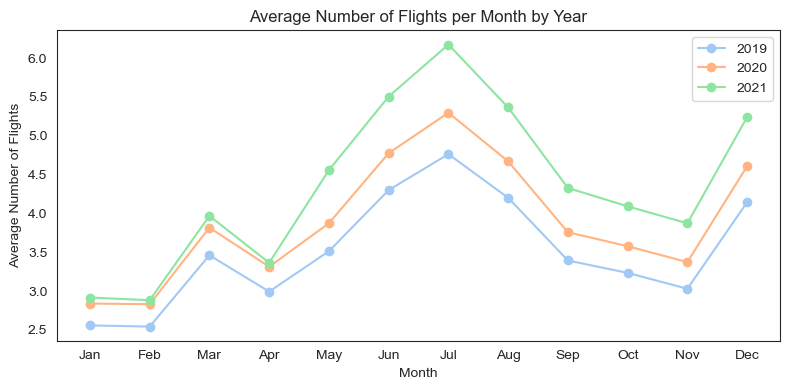

In [ ]:
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.figure(figsize=(8, 4))
for year in [2019, 2020, 2021]:
    monthly_means = []
    for month_name in month_order:
        var_name = f"Flights{month_name}{year}"
        monthly_means.append(customerDB_copy[var_name].mean())
    plt.plot(month_order, monthly_means, marker="o", label=str(year))
plt.title("Average Number of Flights per Month by Year")
plt.xlabel("Month")
plt.ylabel("Average Number of Flights")
plt.legend()
plt.tight_layout()
plt.show()

They all seem to follow the same trend, the only difference being the actual count of flights (increases by year). There's no need to keep such high granularity.

In [ ]:
for year in [2019, 2020, 2021]:
    for month_name, _month in zip(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], range(1, 13), strict=True):
        customerDB_copy.drop([f"Flights{month_name}{year}"], axis=1, inplace=True)
        if f"Flights{month_name}{year}" in customer_numerical_variables: customer_numerical_variables.remove(f"Flights{month_name}{year}")
        if f"Flights{month_name}{year}" in new_customer_variables: new_customer_variables.remove(f"Flights{month_name}{year}")
        if f"Flights{month_name}{year}" in month_variables: month_variables.remove(f"Flights{month_name}{year}")

##### Separate by Month or by Season?

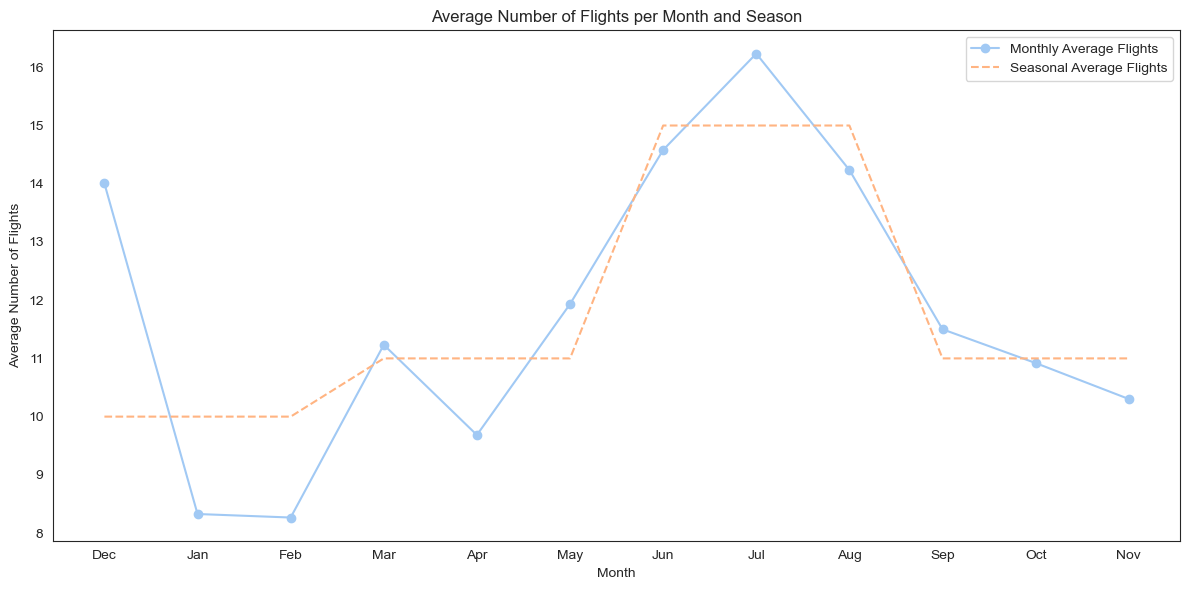

In [ ]:
month_order = ["Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov"]
season_order = { "Winter": ["Dec", "Jan", "Feb"], "Spring": ["Mar", "Apr", "May"], "Summer": ["Jun", "Jul", "Aug"], "Autumn": ["Sep", "Oct", "Nov"] }
plt.figure(figsize=(12, 6))
monthly_means = []
for month_name in month_order:
    var_name = f"Flights{month_name}"
    monthly_means.append(customerDB_copy[var_name].mean())
plt.plot(month_order, monthly_means, marker="o", label="Monthly Average Flights")
seasonal_means = []
for season, months in season_order.items():
    season_mean = (customerDB_copy[f"Flights{season}"].mean()/3).round()
    for _month in months:
        seasonal_means.append(season_mean)
plt.plot(month_order, seasonal_means, linestyle="--", label="Seasonal Average Flights")
plt.title("Average Number of Flights per Month and Season")
plt.xlabel("Month")
plt.ylabel("Average Number of Flights")
plt.legend()
plt.tight_layout()
plt.show()

We'll keep the data separated by months as the seasonal division erases the peak of flights in December (likely caused by Christmas Holidays).

From this visualisation we can already see that the it's most common to travel during Summer and Christmas Holidays, with the peak of average flights being in July and the lowest points in January and February, the remainder of Winter.

In [ ]:
for year in [2019, 2020, 2021]:
    for season, _months in zip(["Winter", "Spring", "Summer", "Autumn"], [[12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]], strict=True):
        if f"Flights{season}" in customerDB_copy.columns:
            customerDB_copy.drop([f"Flights{season}"], axis=1, inplace=True)
            if f"Flights{season}" in customer_numerical_variables: customer_numerical_variables.remove(f"Flights{season}")
            if f"Flights{season}" in new_customer_variables: new_customer_variables.remove(f"Flights{season}")
        if f"Flights{season}{year}" in customerDB_copy.columns:
            customerDB_copy.drop([f"Flights{season}{year}"], axis=1, inplace=True)
            if f"Flights{season}{year}" in customer_numerical_variables: customer_numerical_variables.remove(f"Flights{season}{year}")
            if f"Flights{season}{year}" in new_customer_variables: new_customer_variables.remove(f"Flights{season}{year}")

#### Summary Statistics

In [ ]:
pd.set_option("display.max_rows", None)
customerDB_copy[new_customer_variables].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
FlightsTotal,16737.0,141.05,80.70,0.0,70.00,163.00,203.00,348.00
DistanceKM,16737.0,286387.06,163685.10,0.0,143122.00,330830.00,412908.00,712730.00
KMPerFlight,16737.0,1949.45,1158.56,0.0,1623.83,1976.31,2334.81,31875.00
FlightsRatioAccompanied,15235.0,0.26,0.12,0.0,0.19,0.25,0.32,1.04
DistanceRatioRedeemedPoints,15239.0,0.03,0.05,0.0,0.01,0.02,0.04,3.32
FlightsGrowth2020vs2019%,16737.0,8.50,4.90,0.0,9.09,10.77,11.43,25.00
FlightsGrowth2021vs2020%,16737.0,33.76,271.69,-100.0,-20.00,0.00,22.86,9000.00
MonthlyFlightVariance,16737.0,21.18,10.92,0.0,15.19,23.30,28.99,50.40
CLVperFlight,16737.0,110.10,477.29,0.0,20.09,37.20,76.75,22445.28
CLVperPointsRedeemed,16737.0,0.68,1.12,0.0,0.00,0.34,0.86,16.70


`FlightsTotal`: The slightly lower mean combined with a high maximum of 348 flights shows that most members take fewer than 200 flights, while a smaller subset takes significantly more, stretching the distribution to the right. `DistanceKM` displays a similar pattern, with a mean of 286387km and a median of 330830km, indicating that a few members travel extremely long distances compared to the rest.

`KMsPerFlight` has a mean of ~1949km and a median of 1976km, pointing to an almost balanced central trend overall. However, the maximum value of over 31000km makes it clear that there are strong outliers, meaning the histogram would still appear right-skewed despite similar mean and median values. In other words, most customers fly trips in the 1500 – 2300km range, but a few cases of very long flights stretch the right tail of the distribution. This will have to be treated when working with the outliers.

`FlightsRatioAccompanied` and `DistanceRatioRedeemedPoints` both behave as expected. `FlightsRatioAccompanied` has a mean of 0.26 and a median of 0.25, indicating that most members usually travel alone but occasionally with someone else. `DistanceRatioRedeemedPoints` is right‑skewed, with a mean of 0.03 and median of 0.02, so most customers almost never redeem points.

`FlightsGrowth2020vs2019%` and `FlightsGrowth2021vs2020%` differ substantially. The first variable (max = 25) shows mild variation, with a mean of 4.9 and a median of 0, meaning half the members had no change in flight volume while a few increased slightly and even fewer increased significantly. The second one (max = 9000) shows a huge right‑skew. Its mean jumps to 33.7 while the median stays at 0. This happens because a small set of customers had extremely high growth percentages, and if a customer went from zero or one flight to several, the percentage skyrockets.

`MonthlyFlightVariance` has a mean of 21.2 and median of 23.3, implying that most members have consistent flight habits throughout the year, with only a few showing large month‑to‑month fluctuations.

`CLVperFlight` and `CLVperPointsRedeemed` are heavily right‑skewed; `CLVperFlight` has a mean of 110 and median of 37, while `CLVperPointsRedeemed` has a mean of 0.68 and median of 0.34. A small portion of members generate substantially higher lifetime value relative to their flights or redemptions.

Across Yearly and Monthly flight variables, the pattern remains similar: means are higher than medians, upper quartiles are much lower than the maxima, and many months have a high proportion of zeros, indicating that some members remain inactive for extended periods while a smaller portion accounts for the majority of flight activity.

#### Visualisations

In [ ]:
bar_vars = [
    "Flights2019",
    "Flights2020",
    "Flights2021"
]

hist_box_vars = [
    "FlightsTotal",
    "DistanceKM",
    "KMPerFlight",
    "FlightsRatioAccompanied",
    "DistanceRatioRedeemedPoints",
    "FlightsGrowth2020vs2019%",
    "FlightsGrowth2021vs2020%",
    "MonthlyFlightVariance",
    "CLVperFlight",
    "CLVperPointsRedeemed"
]

corr_vars = [
    "FlightsTotal",
    "DistanceKM",
    "KMPerFlight",
    "CLVperFlight",
    "Customer Lifetime Value",
    "Income",
    "FlightsRatioAccompanied",
    "DistanceRatioRedeemedPoints",
    "CLVperPointsRedeemed",
    "FlightsGrowth2020vs2019%",
    "FlightsGrowth2021vs2020%",
    "MonthlyFlightVariance"
]

##### Bar Plot

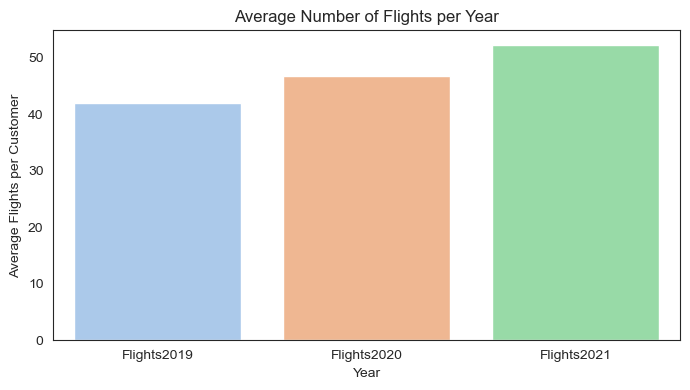

In [ ]:
flights_per_year = customerDB_copy[bar_vars].melt(var_name="Year", value_name="Flights")
plt.figure(figsize=(7, 4))
sns.barplot(x="Year", y="Flights", data=flights_per_year, estimator="mean", errorbar=None, hue="Year")
plt.title("Average Number of Flights per Year")
plt.ylabel("Average Flights per Customer")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

The chart shows a steady increase in the average number of flights per customer from 2019 to 2021. 
<br>
<br>
Customers took around 42 flights on average in 2019, rising to about 46 in 2020 and reaching roughly 52 in 2021. This upward trend indicates consistent growth in flight activity over time, suggesting that customers became more engaged or traveled more frequently each year. The pattern reflects a positive trajectory in overall customer participation and flight usage.

##### Histograms

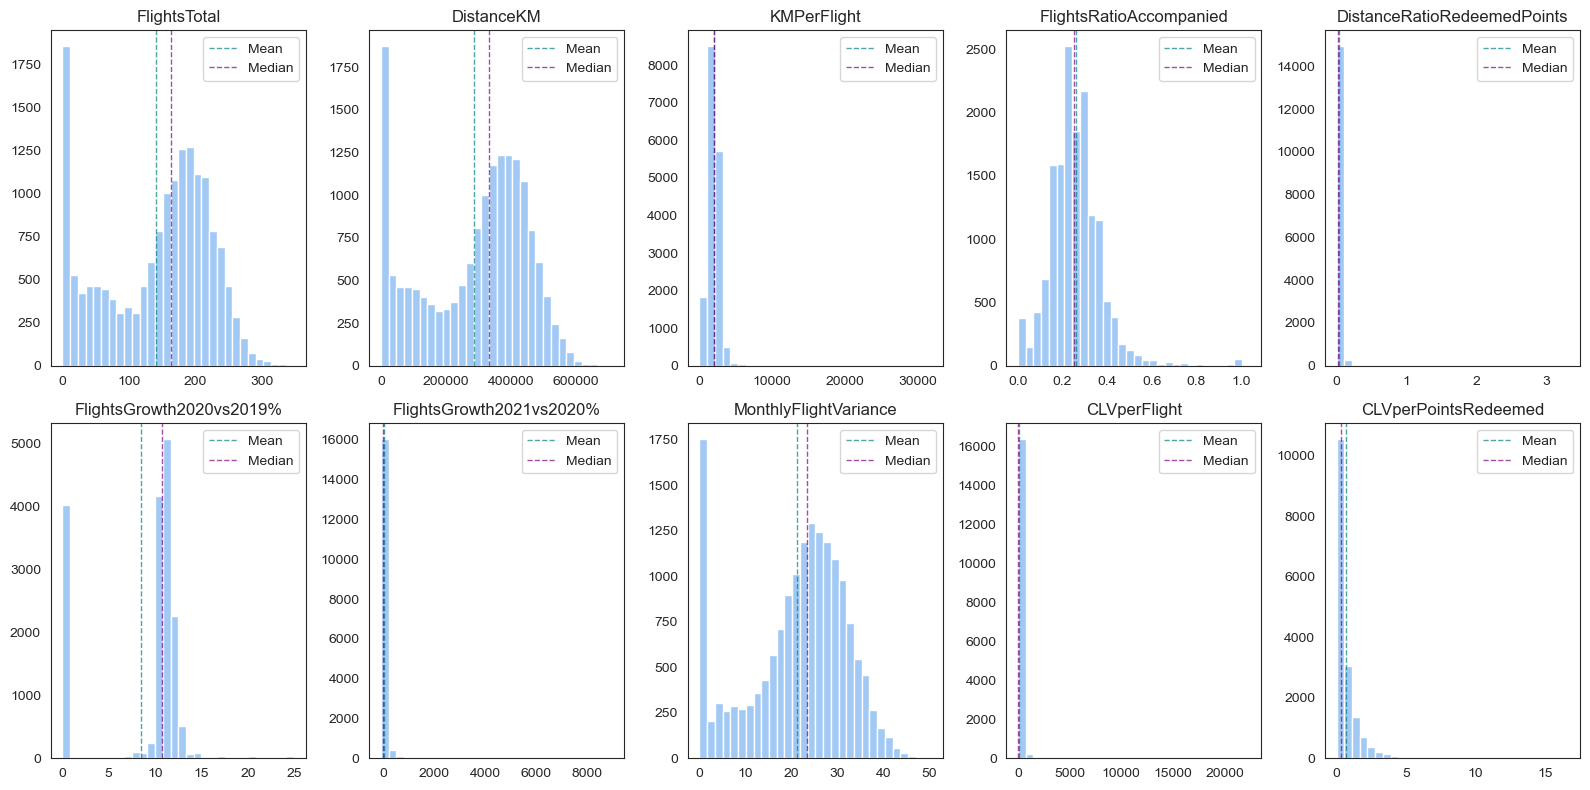

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
axes = axes.flatten()
for i, variable in enumerate(hist_box_vars):
    axes[i].hist(customerDB_copy[variable].dropna(), bins=30)
    axes[i].set_title(variable)
    axes[i].axvline(customerDB_copy[variable].mean(), color="teal", linestyle="dashed", linewidth=1, label="Mean", alpha=0.7)
    axes[i].axvline(customerDB_copy[variable].median(), color="purple", linestyle="dashed", linewidth=1, label="Median", alpha=0.7)
    axes[i].legend()
plt.tight_layout()
plt.show()

`FlightsTotal` looks almost bimodal, with one spike around 0–20 and another broad concentration between roughly 100 and 250 flights. The mean sits just below the median, so the distribution is slightly left‑skewed as expected.

`DistanceKM` has the same shape and pattern as FlightsTotal: two areas of density, one near the lower end and one heavier cluster around 250000–450000km. The mean being smaller than the median indicates mild left‑skew once again. Those with high totals are common enough that the tail does not stretch far to the right.

`KMsPerFlight` is heavily right‑skewed. Nearly all values fall below 5000km, with the frequency dropping off rapidly and outliers extending to over 30000km. This matches the earlier statistical summary: most travelers take short‑ to medium‑haul flights, while a handful make extremely long ones.

`FlightsRatioAccompanied` shows a mild right‑skew and looks roughly bell‑shaped around 0.25. The mean and median coincide closely, confirming that most travelers fall near that ratio, usually flying alone but sometimes with others. Only a few outliers exist beyond 0.6.

`DistanceRatioRedeemedPoints` is extremely concentrated near zero with a thin, extended tail. Practically all observations are under 0.2, but a few go beyond 1 or even 3, which pushes the mean slightly above the median. This tall narrow spike reflects the majority of members who rarely redeem points, with very few heavy redeemers influencing the average.

`FlightsGrowth2020vs2019%` shows two distinct peaks: one tall bar around zero and another smaller cluster around 10%. The mean sits moderately below that second cluster, indicating the dominance of stable or minimally changing members with only a small segment showing positive growth.

`FlightsGrowth2021vs2020%` is sharply right‑skewed, with a huge pileup at zero and a long sparse tail stretching beyond 8000%. The near‑zero median and very high mean replicate exactly what the summary showed: most customers unchanged, but a handful with extreme percentage increases due to small denominators.

`MonthlyFlightVariance` is nearly symmetric with a slight rightward lean. Ignoring the left-peak around 0, most members cluster between 15 and 30, with the mean just left of the central peak and the median slightly higher. That shape suggests that while the majority have consistent travel behavior each month, there are still a few with more irregular schedules increasing the upper spread.

`CLVperFlight` and `CLVperPointsRedeemed` are both dominated by a towering bar at zero and a long, almost flat right tail. Almost everyone contributes relatively low value, but the tiny set of customers to the far right create extremely large values that pull the mean a little above the median. These distributions visually confirm the right‑skew and the presence of outliers identified in the stats.

##### Box Plots

Number of outliers in FlightsTotal: 0
Number of outliers in DistanceKM: 0
Number of outliers in KMPerFlight: 2085
Number of outliers in FlightsRatioAccompanied: 347
Number of outliers in DistanceRatioRedeemedPoints: 753
Number of outliers in FlightsGrowth2020vs2019%: 4132
Number of outliers in FlightsGrowth2021vs2020%: 2173
Number of outliers in MonthlyFlightVariance: 3
Number of outliers in CLVperFlight: 1885
Number of outliers in CLVperPointsRedeemed: 1145


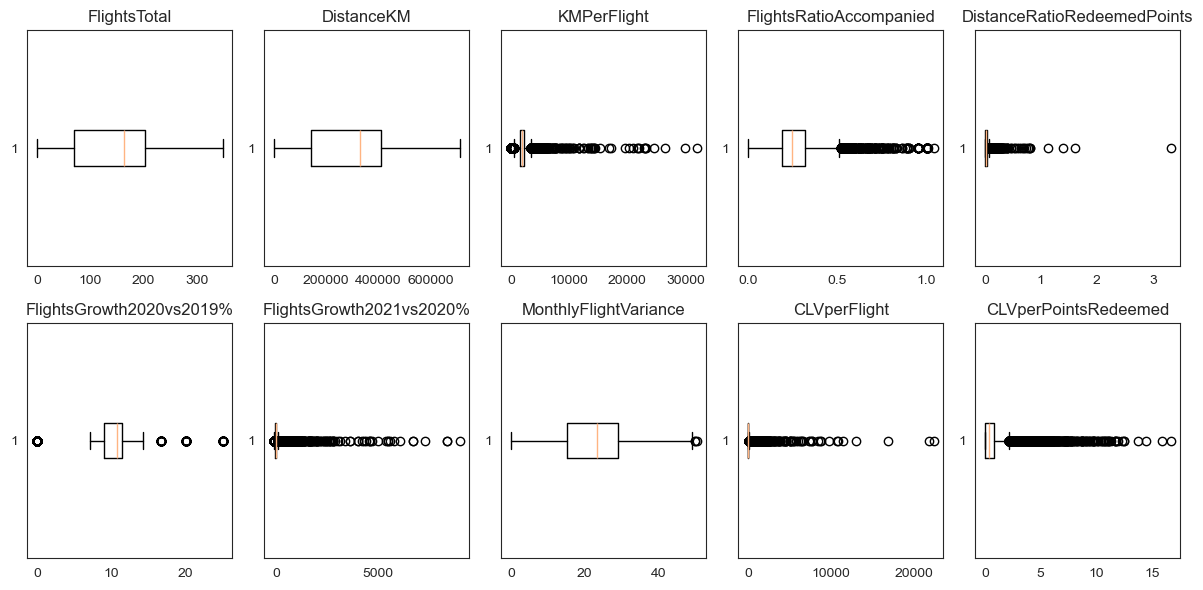

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
axes = axes.flatten()
for i, variable in enumerate(hist_box_vars):
    axes[i].boxplot(customerDB_copy[variable].dropna(), vert=False)
    axes[i].set_title(variable)

    Q1 = customerDB_copy[variable].quantile(0.25)
    Q3 = customerDB_copy[variable].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = customerDB_copy[(customerDB_copy[variable] < lower_bound) |
                                   (customerDB_copy[variable] > upper_bound)]

    print(f"Number of outliers in {variable}:", outliers.shape[0])
plt.tight_layout()
plt.show()

The box plots confirm the same patterns seen earlier while the outlier counts make those differences clearer.

`FlightsTotal` and `DistanceKM` show no outliers, meaning most members behave similarly in total activity and distance traveled. `KMsPerFlight`, on the other hand, displays a strong right-skew with over 2,000 outliers, confirming that a few members flew exceptionally long routes.

The ratio variables show moderate deviation as `FlightsRatioAccompanied` has 347 outliers and `DistanceRatioRedeemedPoints` 753, indicating that most travelers stay near average ratios while a small subset fly more often with others or redeem points far more frequently.

Growth variables are the most uneven: `FlightsGrowth2020vs2019%` and `FlightsGrowth2021vs2020%` have 4,132 and 2,173 outliers respectively. In the first case, this is likely due to the fact that the values present in the first peak we identified in the histogram are being considered outliers. In the second case, while most members saw basically no change, a handful had very large percentage increases due to tiny baselines.

`MonthlyFlightVariance` has just three outliers, confirming stable flight patterns for nearly everyone.

`CLVperFlight` and `CLVperPointsRedeemed` show large spreads with 1,885 and 1,145 outliers, revealing that a small group of very high-value members account for the right tails and much of the variation.

Overall, the boxplots and outlier counts reinforce that most customers exhibit moderate, consistent behavior, while a limited number of extreme cases dominate the upper ends of several variables.

##### Heatmap

<Axes: >

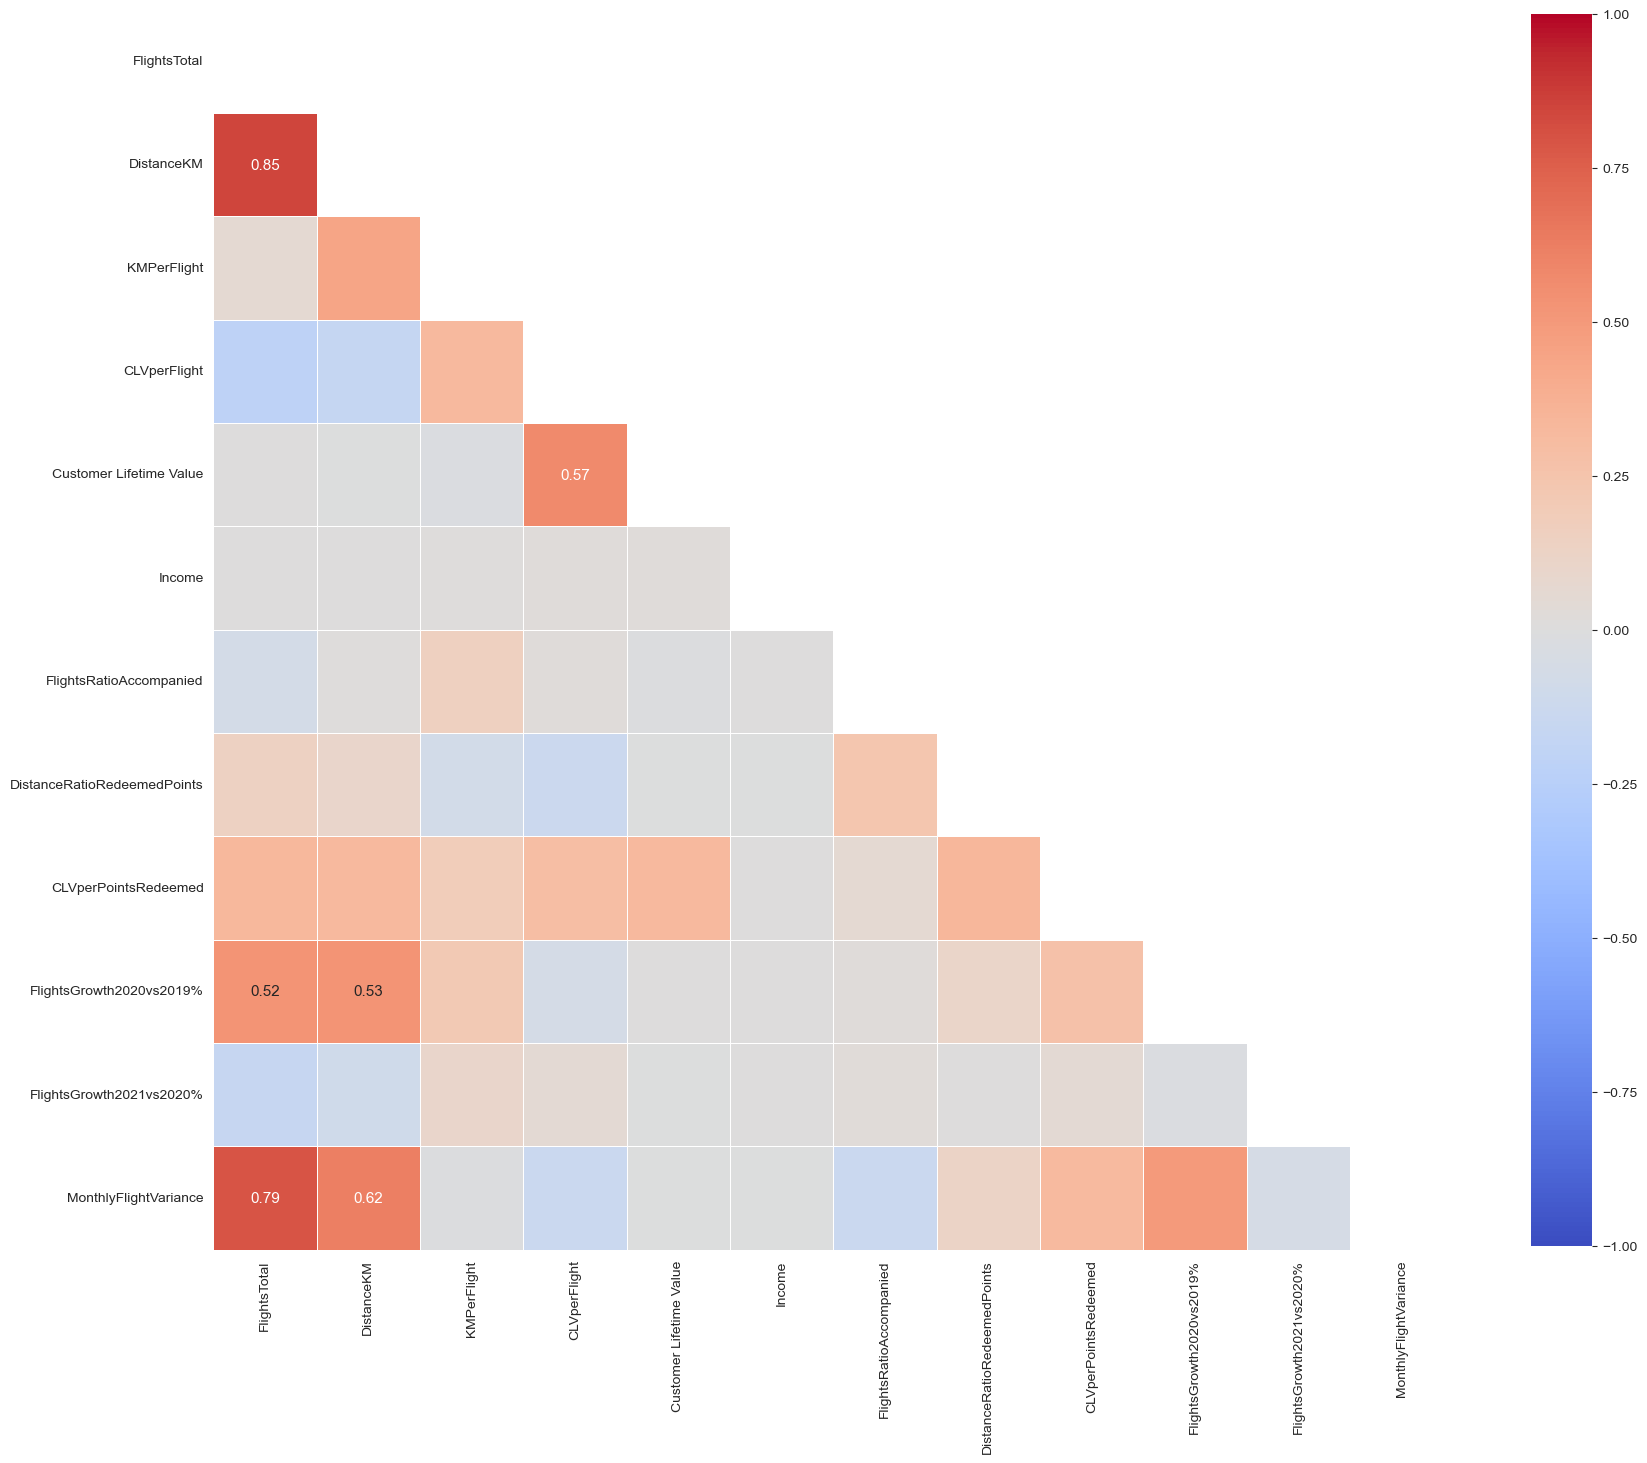

In [ ]:
corr = customerDB_copy[corr_vars].corr(method="spearman")

fig, ax = plt.subplots(figsize=(20, 20))
annot = corr.round(2).astype(str)
weak_mask = corr.abs() < 0.5
annot = annot.where(~weak_mask, "")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr,
    annot=annot,
    mask=mask,
    vmin=-1, vmax=1,
    square=True,
    cmap="coolwarm",
    fmt="s",
    linewidths=.5,
    annot_kws={"size": 11},
    cbar_kws={"shrink": 0.8},
    ax=ax
)

- `FlightsTotal` - `DistanceKM` (0.85): Strong positive relationship. Customers who take more flights also travel longer total distances, showing consistent engagement and high travel activity.
- `FlightsTotal` - `MonthlyFlightVariance` (0.79): Frequent flyers tend to have greater month-to-month variation, suggesting irregular but intensive travel patterns
- `MonthlyFlightVariance` - `DistanceKM` (0.62): Customers who fly longer distances usually show higher variability in their monthly flights, indicating less consistent but larger travel events.
- `FlightsGrowth2020vs2019%` - `FlightsTotal` (0.52): Customers who already flew often were also more likely to increase their flight activity between 2019 and 2020.
- `FlightsGrowth2020vs2019%` - `DistanceKM` (0.53): Travelers covering greater distances were also those with notable growth in flight frequency, suggesting expansion in travel activity among long-distance flyers.
- `CLVperFlight` - `Customer Lifetime Value` (0.57): Higher-value customers tend to generate more revenue per flight, meaning profitability scales with customer loyalty and flight activity.

##### Hexbin Plots

Similar to what we did in the separate datasets analysis, we will ignore the values with zero flights as they all make the plots look heavily concentrated in the bottom-left area.

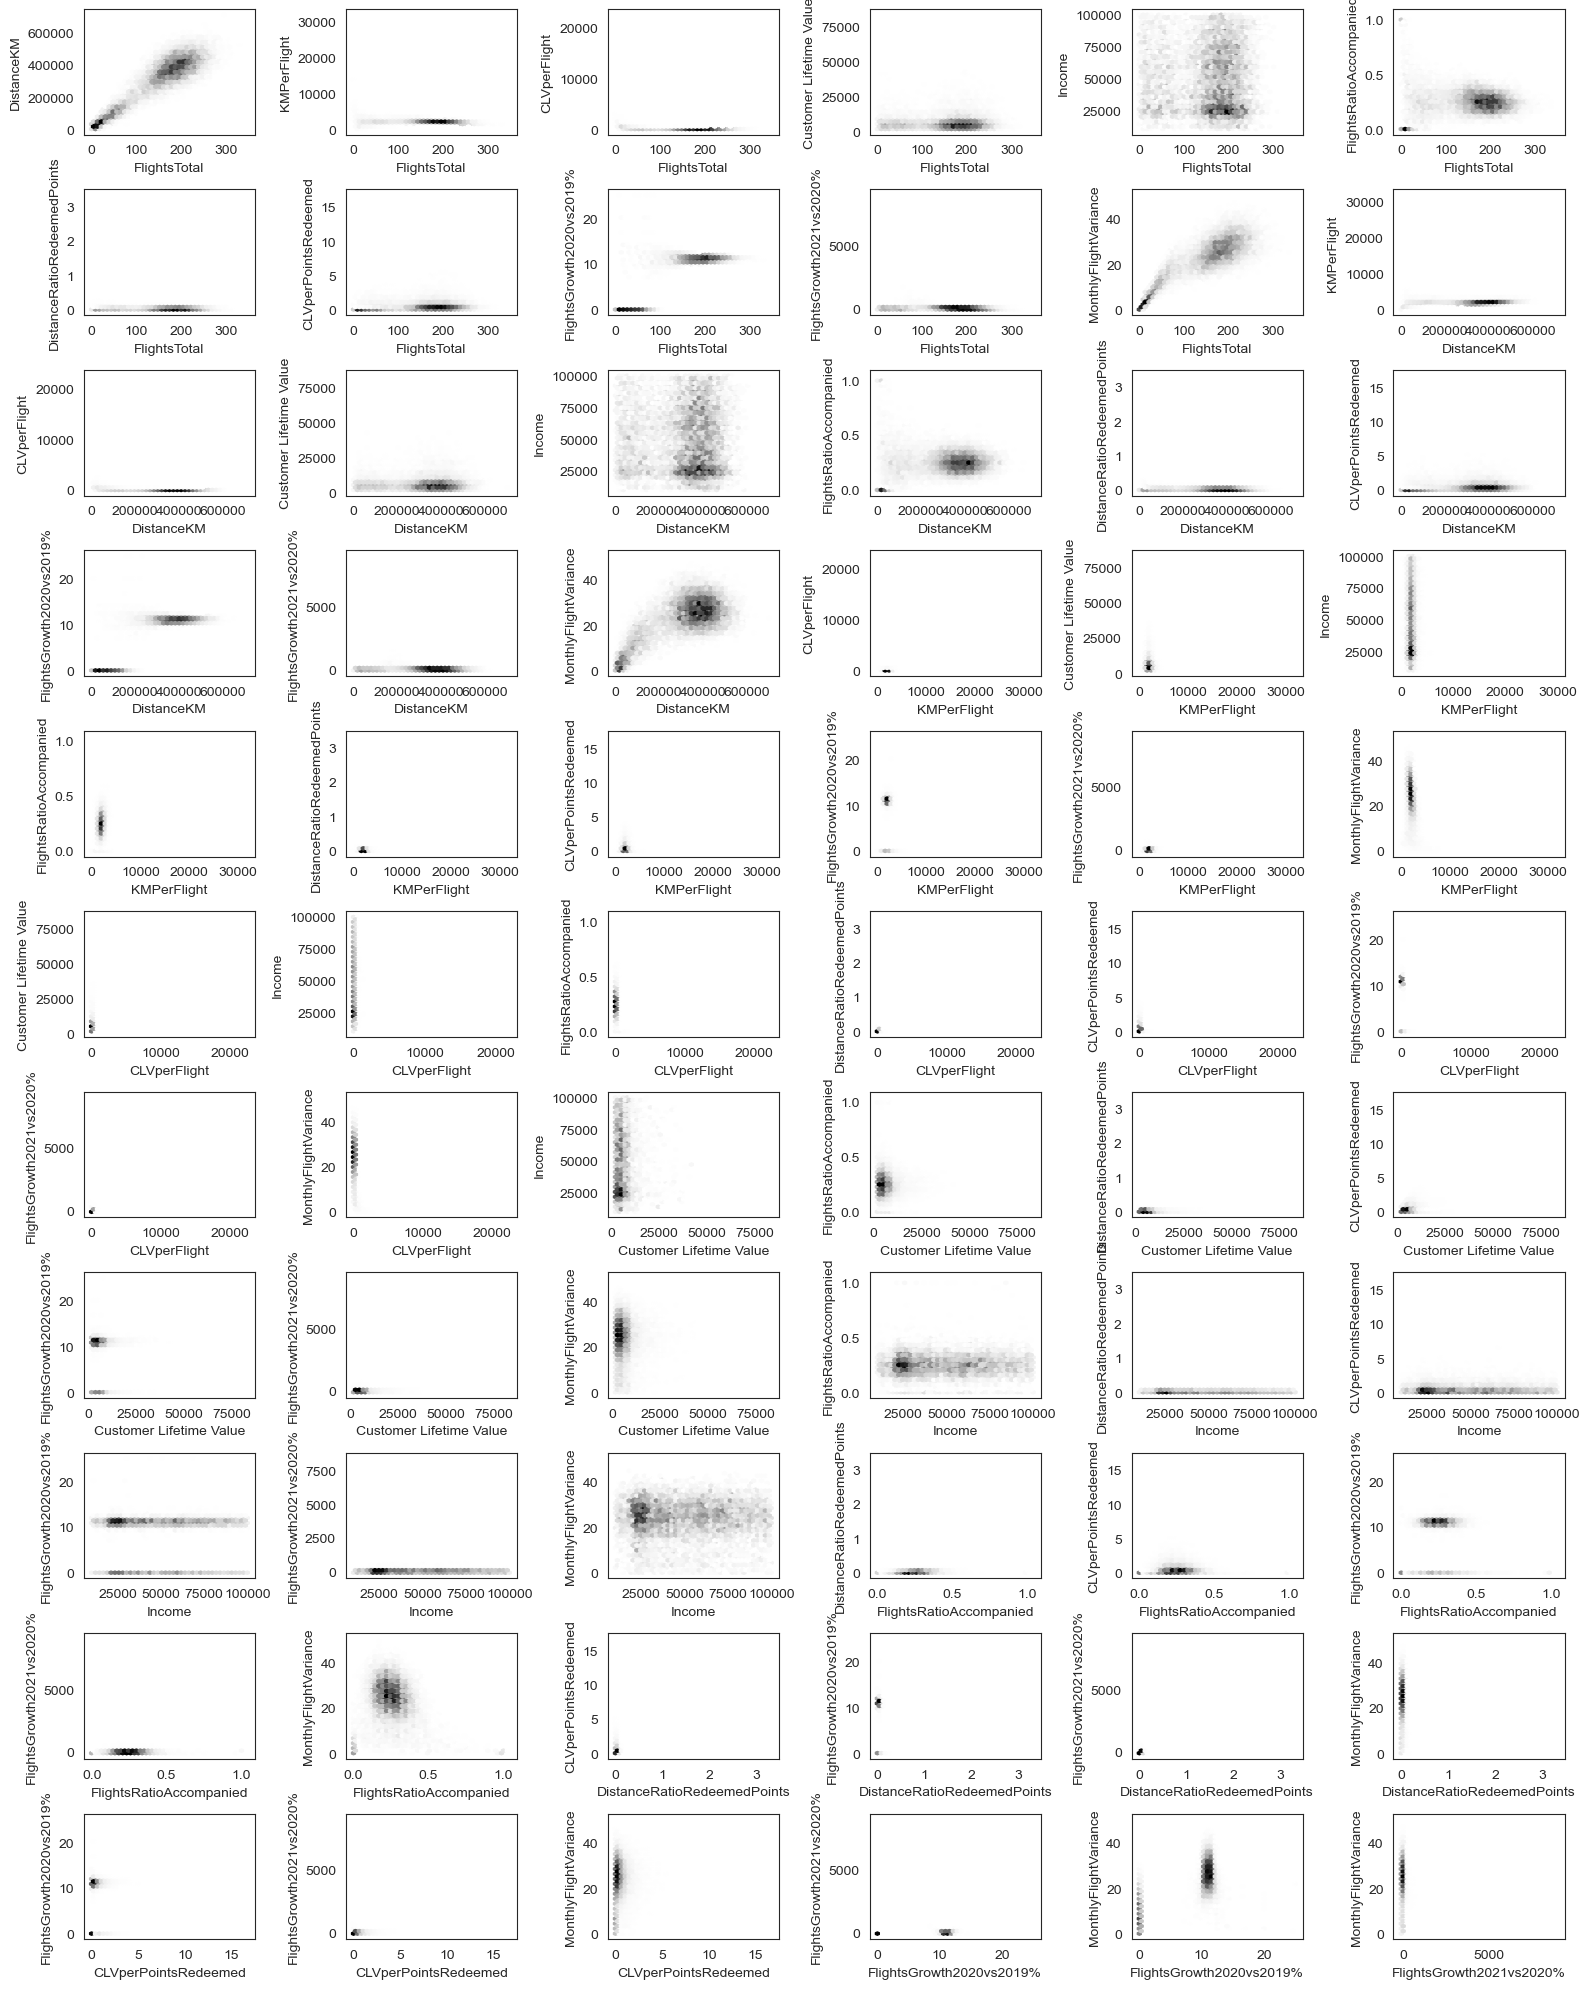

In [ ]:
corr_var_pairs = list(itertools.combinations(corr_vars, 2))
flight_nonzero = customerDB_copy[customerDB_copy["FlightsTotal"] != 0]
fig, axes = plt.subplots(nrows=11, ncols=6, figsize=(16, 20))
axes = axes.flatten()
for ax, (var1, var2) in zip(axes, corr_var_pairs, strict=True):
    ax.hexbin(flight_nonzero[var1], flight_nonzero[var2], gridsize=40, cmap="Greys", mincnt=1)
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)
plt.tight_layout()
plt.show()

Because zero‑flight members were excluded, the relationships focus only on active travelers.

The `DistanceKM` vs `FlightsTotal` plot shows a very strong and clear positive relationship. The dense diagonal pattern indicates that members who fly more also accumulate proportionally greater distances. The slight dispersion in the upper ranges suggests that although total flights and distance scale tightly, the average distance per flight varies somewhat among highly active members.

The pair `FlightsTotal` and `DistanceKM` vs `Income` display no clear trend. Points are scattered in vertical columns, meaning income does not systematically increase or decrease with how often or far someone flies. Most members remain concentrated around moderate income levels across all activity and distance ranges.

`FlightsRatioAccompanied` vs `FlightsTotal` shows a dense central blob around 0.2-0.4, with no directional trend, confirming near‑zero correlation between how frequently members fly and how often they fly with companions. The ratio remains roughly constant for high and low flyers alike, matching the earlier histogram and boxplot conclusions that companionship behavior is stable across traveler types.

`FlightsTotal` vs `MonthlyFlightVariance` shows another strong positive linear pattern. The hexagonal density increases along a visible upward slope, confirming that as total flight activity grows, variability across months rises too. However, even among those who fly the most, the spread remains moderate—suggesting regular but more frequent travel rather than erratic peaks.

`FlightsGrowth2020vs2019%` vs `FlightsTotal` presents a flat pattern: a dense cluster near zero and a thinner one near 10%, mostly independent of flight volume. This indicates that yearly growth percentages were fairly consistent across all travel levels.

***

## 5. <a id="5">Clustering</a>

***

## 6. <a id="6">Evaluation</a>

***

## 7. <a id="7">Suggestions</a>

***